#### 1- Consider the daily returns of Amazon (amzn) stock from January 2, 2009 to December 31,2014. The simple returns are available from CRSP and in the file d-amzn3dx0914.txt (the column with heading amzn). Transform the simple returns to log returns. Multiply the log returns by 100 to obtain the percentage returns. Let 𝑟 be the percentage log returns.

(a) Is the expected value of 𝑟 zero? Why? Are there any serial correlations in 𝑟? Why? 

(b) Fit a GARCH(1,1) model with normal innovations to the 𝑟 series. Write down the fitted model. Is the model adequate? Why? 

(c) Build a GARCH(1,1) model with Student-t innovations for the log return series. Perform model checking and write down the fitted model. 

(d) Obtain 1-step to 5-step ahead mean and volatility forecasts using the fitted GARCH model with Student-t innovations. 

In [9]:
library(quantmod)
#install.packages(c('rugarch','lubridate','PerformanceAnalytics','fBasics'))
library('rugarch')
library('lubridate')
library('PerformanceAnalytics')
library('fBasics')

Loading required package: parallel


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'PerformanceAnalytics'


The following object is masked from 'package:graphics':

    legend



Attaching package: 'fBasics'


The following objects are masked from 'package:PerformanceAnalytics':

    kurtosis, skewness


The following objects are masked from 'package:rugarch':

    qgh, qnig


The following object is masked from 'package:TTR':

    volatility




In [10]:
a = read.table("d-amzn3dx0914.txt", header = T)
a = a[,2:3]
a$date = ymd(a$date)
a = xts(a,a$date)
a$date =NULL
storage.mode(a) = "numeric"
a = 100*log(1+a$amzn) #Converting to log returns and multiplying 100
head(a)

                 amzn
2009-01-02  5.8327397
2009-01-05 -0.5534286
2009-01-06  5.9252387
2009-01-07 -2.0430284
2009-01-08  1.6937743
2009-01-09 -2.9290818

In [11]:
str(a)

An xts object on 2009-01-02 / 2014-12-31 containing: 
  Data:    double [1510, 1]
  Columns: amzn
  Index:   Date [1510] (TZ: "UTC")


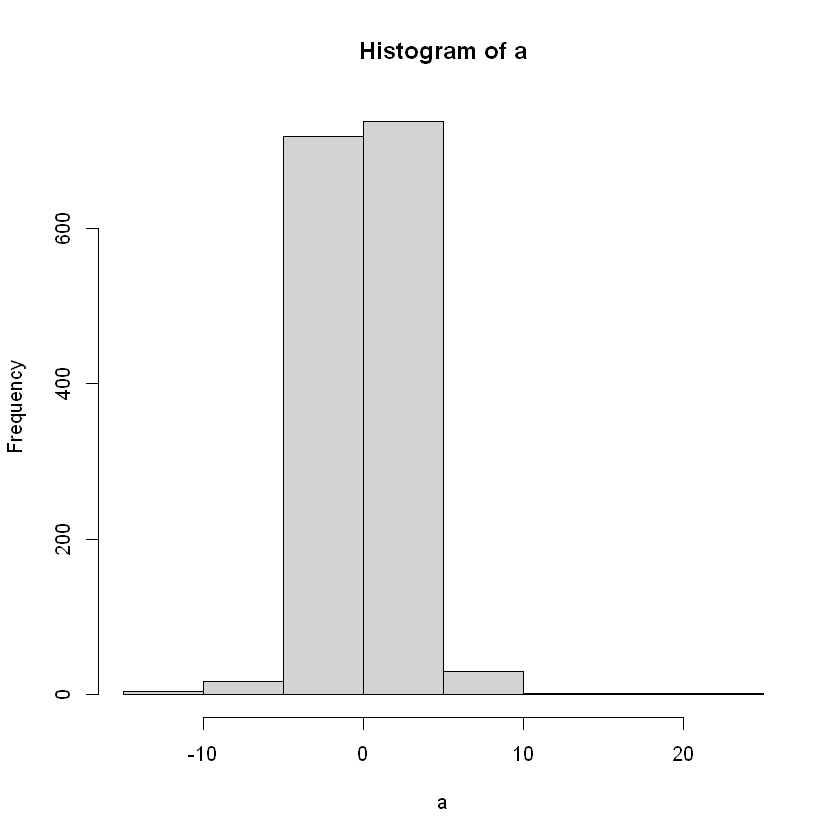

In [12]:
hist(a)

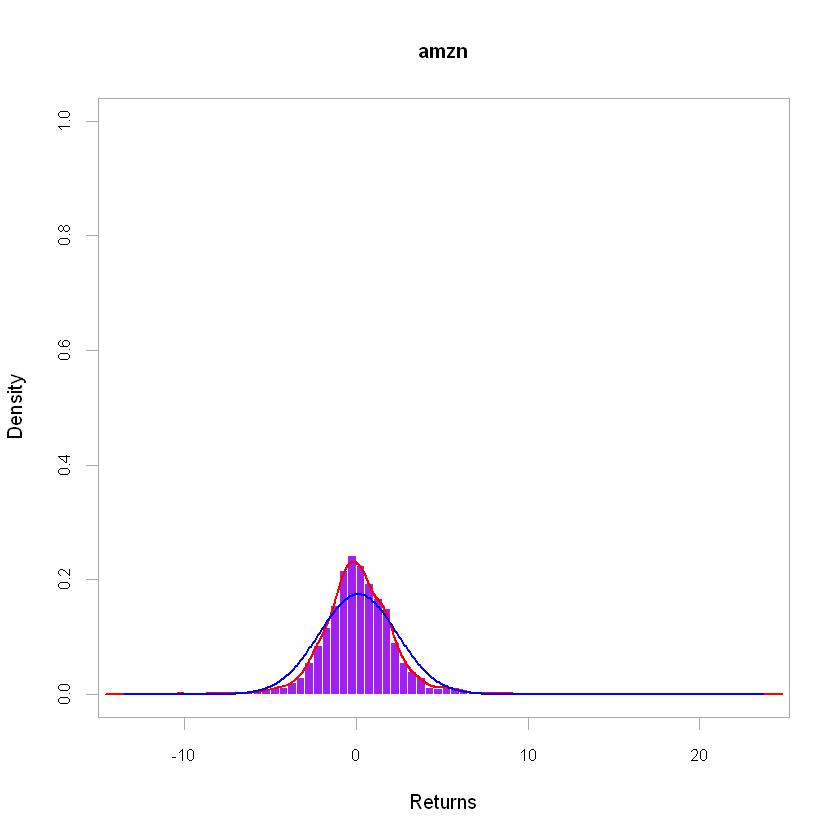

In [13]:
chart.Histogram(a,methods = c("add.density","add.normal"),
                colorset = c("purple","red","blue"))

Looks like tails are thicker and hence t-distribution should be considered for returns.

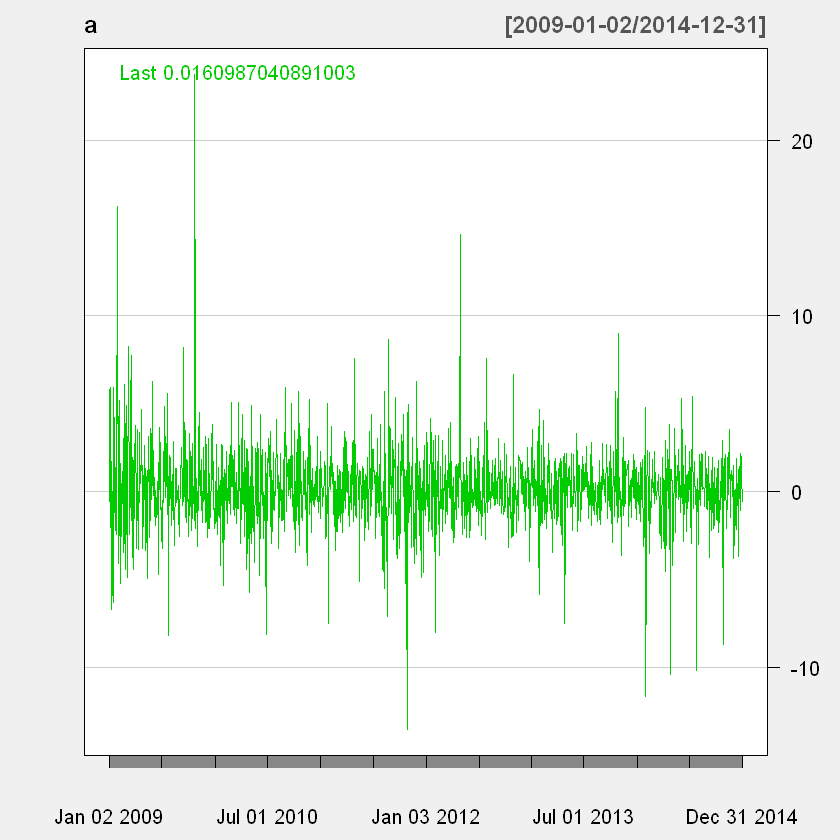

In [14]:
chartSeries(a,theme = "white")

Looks like mean stationary time series, without any trend. But there are clusters of high and low volatility.

In [15]:
basicStats(a)

amzn       
nobs        1510.000000
NAs            0.000000
Minimum      -13.532500
Maximum       23.740221
1. Quartile   -1.044486
3. Quartile    1.321801
Mean           0.119231
Median         0.048838
Sum          180.038980
SE Mean        0.058745
LCL Mean       0.004000
UCL Mean       0.234463
Variance       5.211055
Stdev          2.282773
Skewness       0.847814
Kurtosis      12.434261

In [16]:
t.test(a)

Warning message in tstat + c(-cint, cint):
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead."
Warning message in cint * stderr:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead."



	One Sample t-test

data:  a
t = 2.0296, df = 1509, p-value = 0.04257
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.003999691 0.234462533
sample estimates:
mean of x 
0.1192311 


The mean does not seem to be zero as confirmed by t.test.

Since, p-value < 0.05, we can reject the Null Hypothesis (mean of the series is zero).

Now,lets check Autocorrelation for the series:

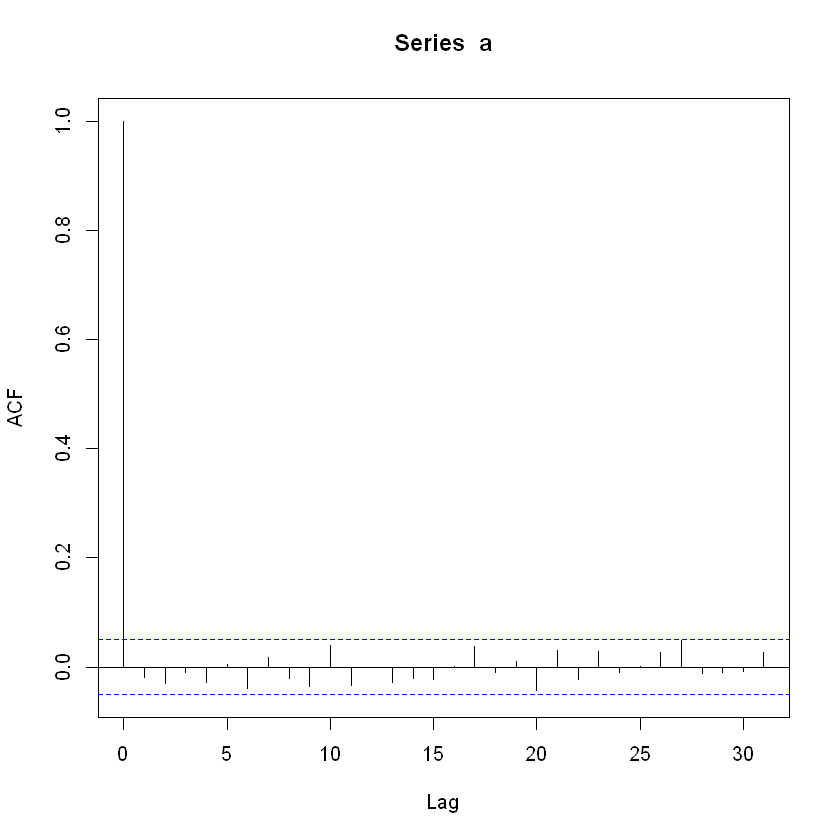

In [17]:
acf(a)

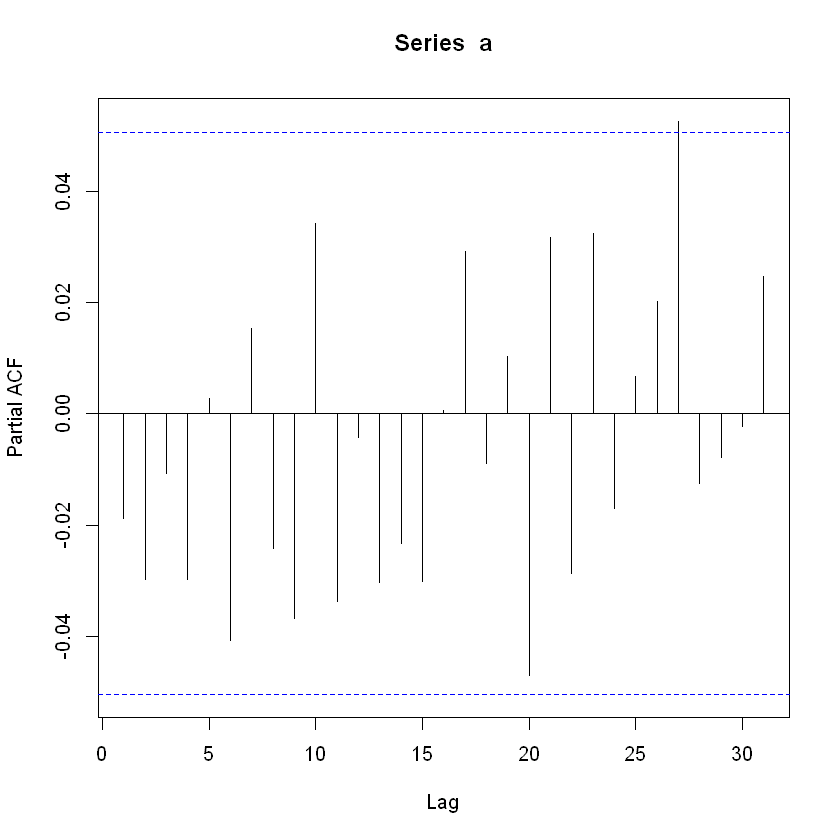

In [18]:
pacf(a)

In [19]:
Box.test(a,lag = 10, type = "Ljung")


	Box-Ljung test

data:  a
X-squared = 10.974, df = 10, p-value = 0.3595


There seems to be no significant spike for ACF and PACF of log returns. This can be confirmed by box-test(Ljung). Since, p-value > 0.05, we fail to reject Null Hypothesis that Auto-Correlation upto lag 10 are zero.

Lets check Auto-Correlations for Squared series

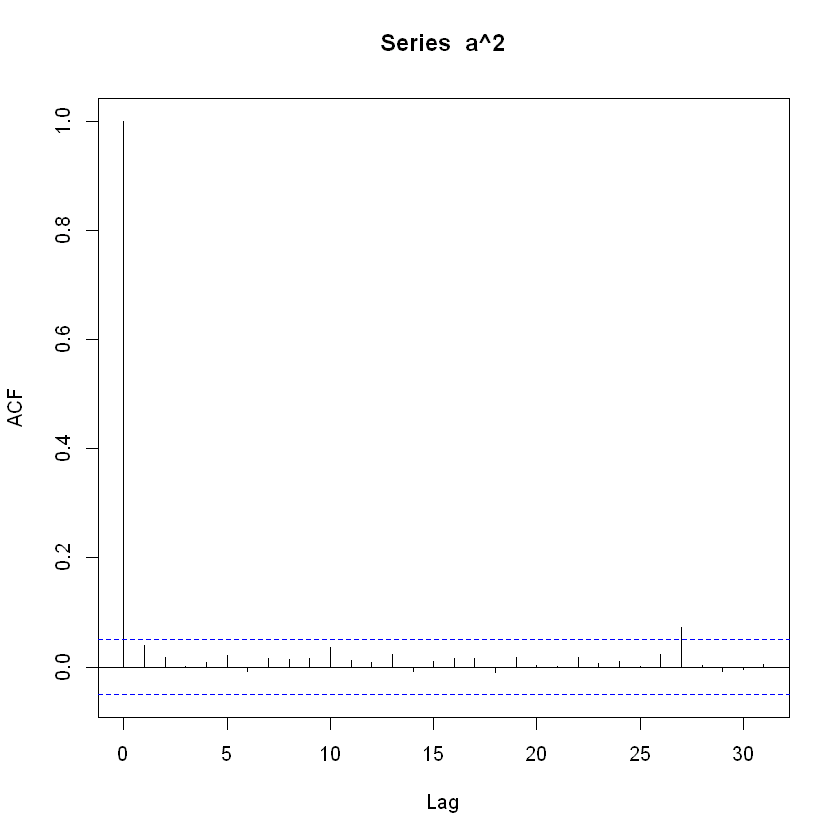

In [20]:
acf(a^2)

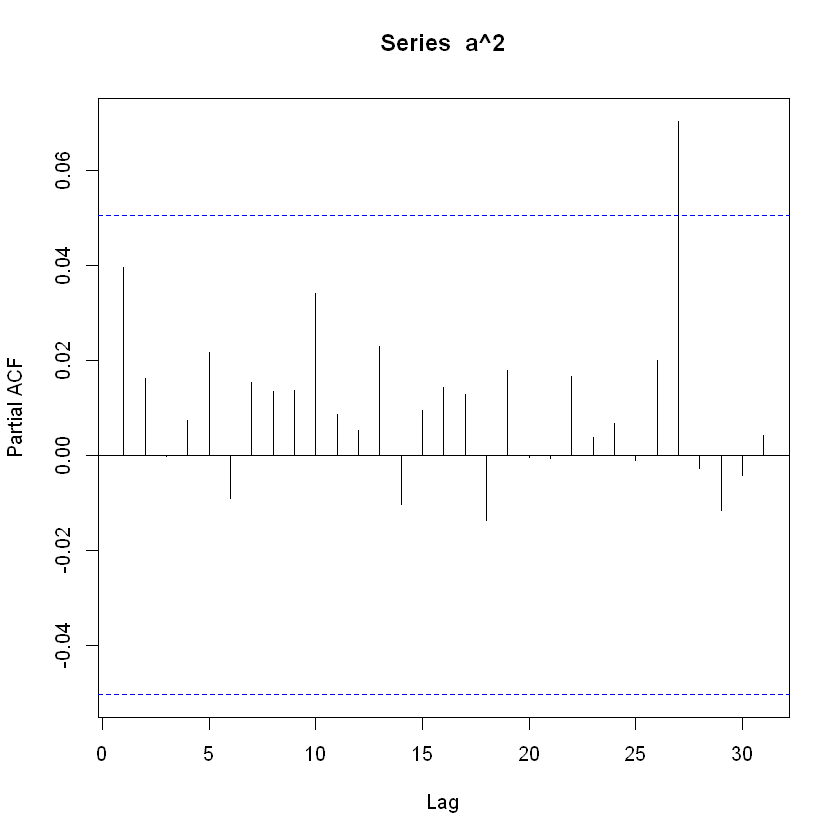

In [21]:
pacf(a^2)

In [22]:
Box.test(a^2,lag = 10, type = "Ljung")


	Box-Ljung test

data:  a^2
X-squared = 6.7151, df = 10, p-value = 0.752


Again we can not see any Auto-correlation for squared values of series.

I have used “rugarch” package for this question , just for learning purpose. I just wanted to explore this package along with fGarch package. Hope this will not cause any issue in analysis Lets Fit Garch(1,1):

In [23]:
s  = ugarchspec(mean.model = list(armaOrder = c(0,0)),
                variance.model = 
                list(model="sGARCH",garchOrder = c(1,1)),
                distribution.model = "norm")

mod1 = ugarchfit(data = a,spec = s)
mod1


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.109363    0.056675    1.9297 0.053650
omega   0.023032    0.005897    3.9059 0.000094
alpha1  0.007252    0.001621    4.4739 0.000008
beta1   0.987686    0.000758 1302.8981 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.109363    0.052929    2.0662 0.038808
omega   0.023032    0.014680    1.5689 0.116678
alpha1  0.007252    0.004172    1.7382 0.082168
beta1   0.987686    0.000882 1119.9290 0.000000

LogLikelihood : -3365.187 

Information Criteria
------------------------------------
                   
Akaike       4.4625
Bayes        4.4766
Shibata      4.4625
Hannan-Quinn 4.4677

In [24]:
coef(mod1)

mu       omega      alpha1       beta1 
0.109363401 0.023031683 0.007251865 0.987685625

All parameters looks significant except mu. The fitted Model can be written as:

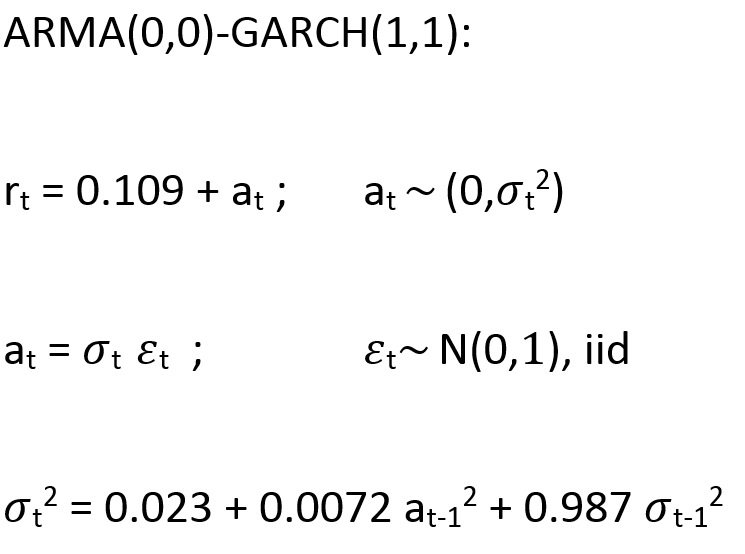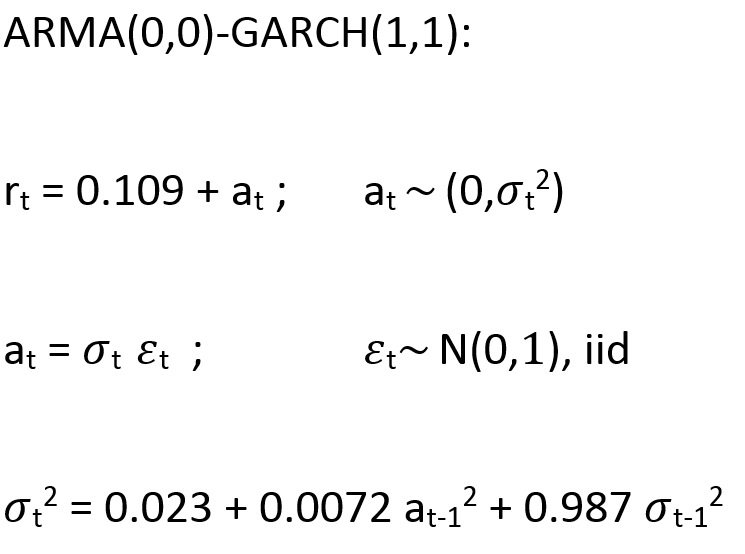

We assumed normal distribution for residuals in the model.But if we look at Pearson Goodness of fit Test, all p-values < 0.05 , indicating that our assumption is not correct and there is scope to improve the model by using may be t-distribution for residuals.


please wait...calculating quantiles...


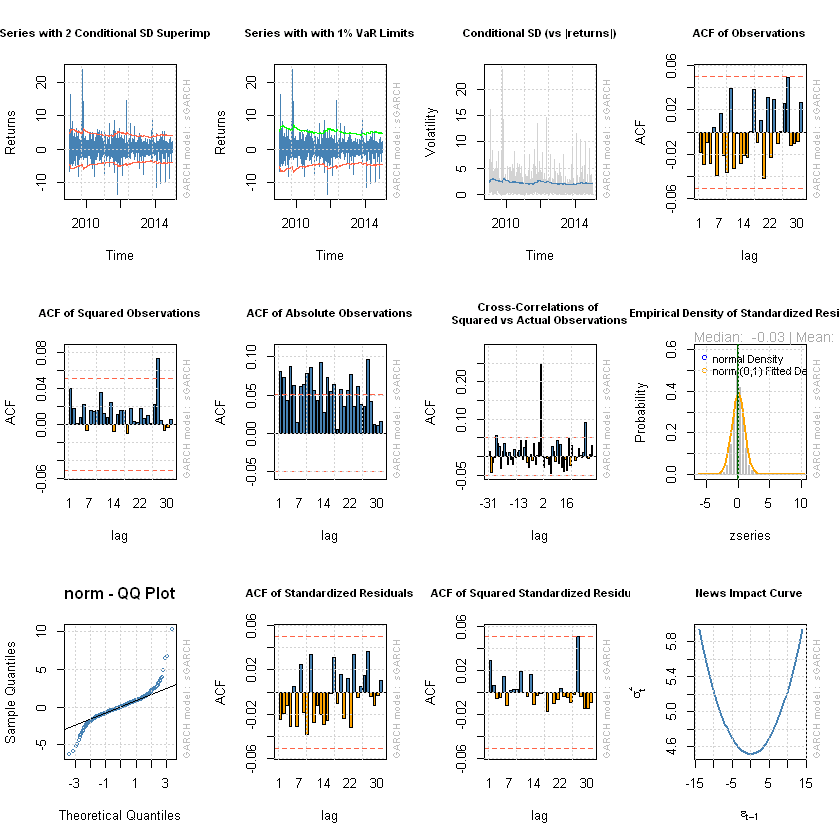

In [25]:
plot(mod1,which = "all")

Observing the Histogram & QQ-plot for residuals, we can say that distribution is different from normal distribution. The tails for both higher and lower values are deviating significantly from normal distribution = thicker tails.

The Ljung-Box Test for standardized residuals as well as standaradized squared residuals gives p-value > 0.05. This indicates that we fail to reject Null Hypothesis (No serial correlation). hence we can say that there is no serial correlation and residuals are acting as white noise. This can be verified looking at the ACF charts also. This imply that our model is adequate.

AIC value = 4.462

#### Lets consider student-t distribution for residuals and fit a GARCH(1,1)

In [26]:
s2  = ugarchspec(mean.model = list(armaOrder = c(0,0)),
                variance.model = 
                list(model="sGARCH",garchOrder = c(1,1)),
                distribution.model = "std")
mod2 = ugarchfit(data = a, spec = s2 )
mod2


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.087060    0.046113   1.8880 0.059032
omega   0.060535    0.017407   3.4776 0.000506
alpha1  0.017064    0.003726   4.5796 0.000005
beta1   0.968300    0.004272 226.6839 0.000000
shape   4.311221    0.428313  10.0656 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.087060    0.041887   2.0785 0.037665
omega   0.060535    0.015855   3.8181 0.000134
alpha1  0.017064    0.003701   4.6111 0.000004
beta1   0.968300    0.001813 534.1900 0.000000
shape   4.311221    0.452458   9.5284 0.000000

LogLikelihood : -3195.838 

Information Criteria
------------------------------------
                

The model can be written as:

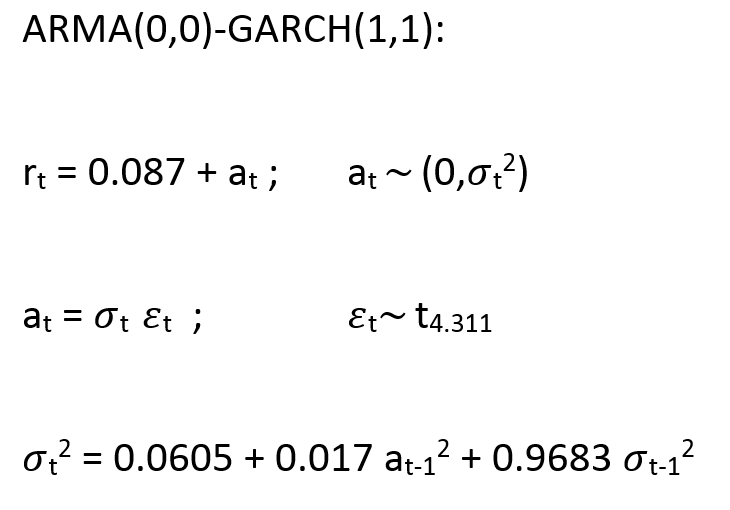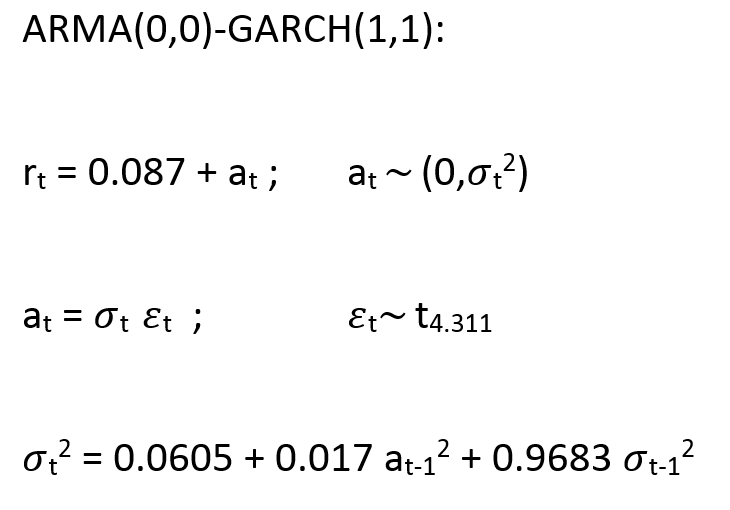


please wait...calculating quantiles...


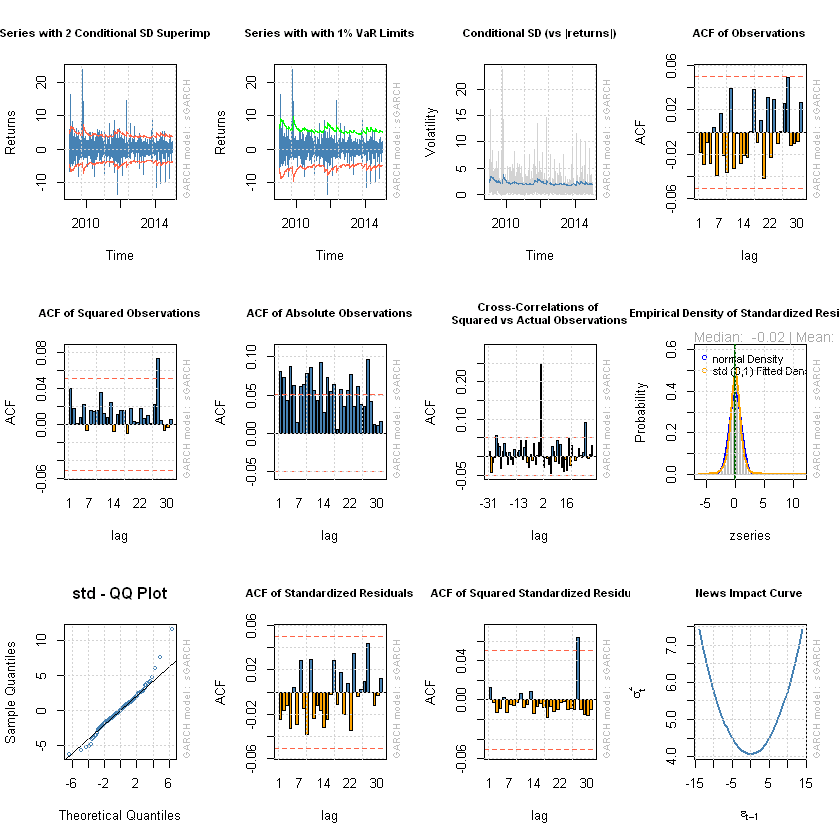

In [27]:
plot(mod2,which = "all")

Observations from the model:

1. Value of mu is not significant.

2. The ACF of Standardized residuals is showing no significant spike.

3. The ACF of squared residuals is also not showing any significant spike except at lag-27.

4. The residuals can be considered white noise.

5. QQ-plot is giving a better fit of data (Emperical vs Theoretical quantiles). Still it is not perfect.

6. AIC Value = 4.239

Based on AIC values, we can say that mod2 is better than previous model.

#### 1-step to 5-step ahead mean and volatility forecasts:

In [28]:
f = ugarchforecast(fitORspec = mod2, n.ahead = 5)
f


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 5
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=2014-12-31]:
     Series Sigma
T+1 0.08706 1.873
T+2 0.08706 1.876
T+3 0.08706 1.878
T+4 0.08706 1.881
T+5 0.08706 1.883



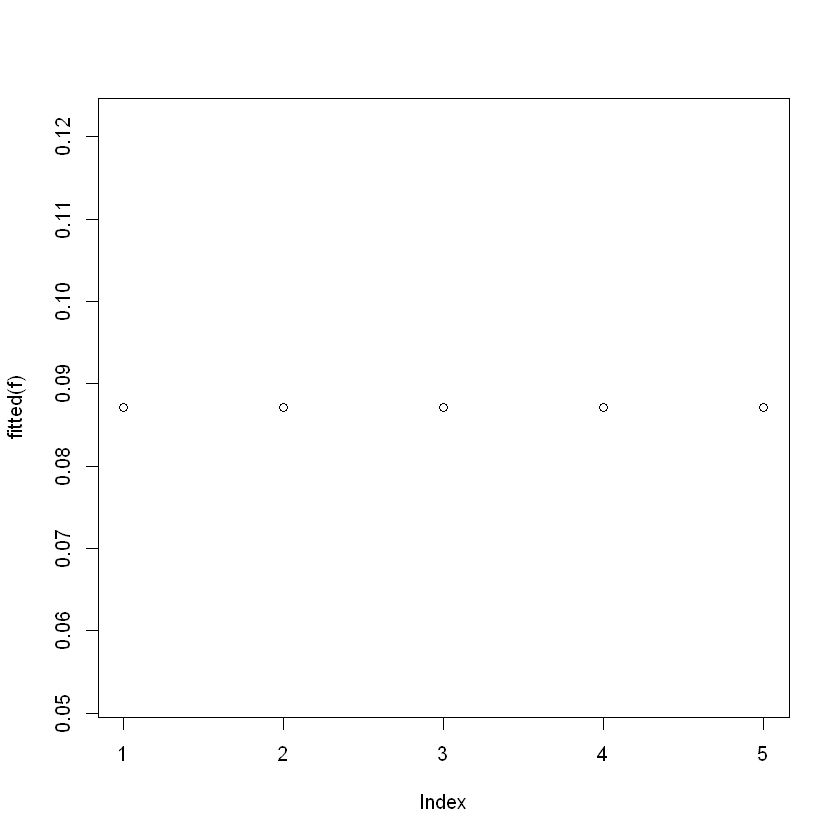

In [29]:
plot(fitted(f))

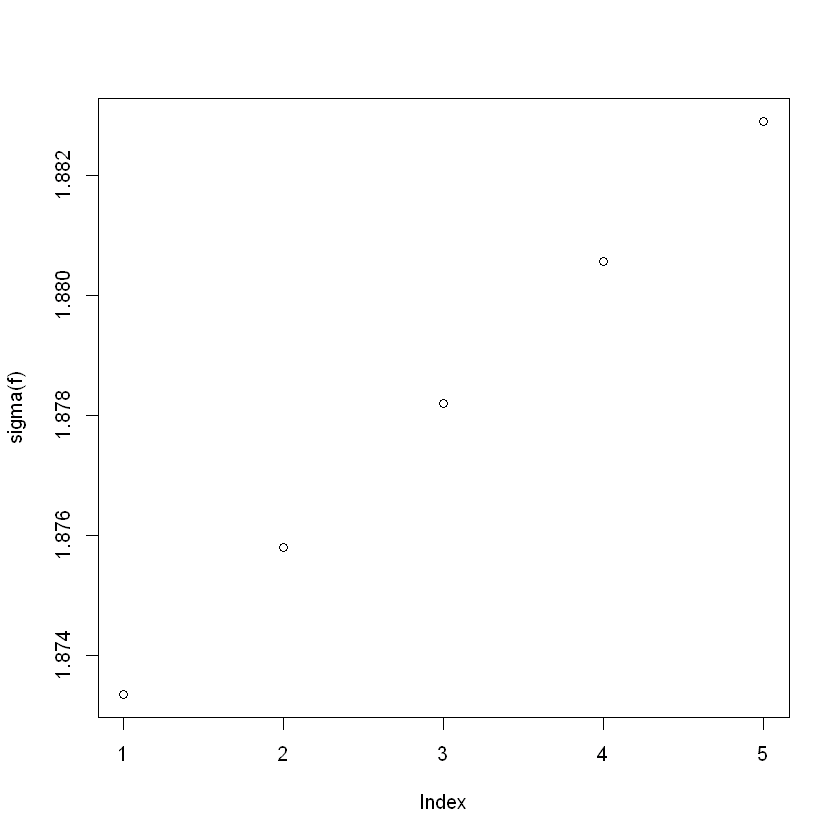

In [30]:
plot(sigma(f))

Since, we are using constant mean model, so our predictions are almost same.

Looking at predicted sigma value, model expects volatility to increase in next 5 days.

#### 2- Consider again the daily log returns of Amazon stock in Problem 1.

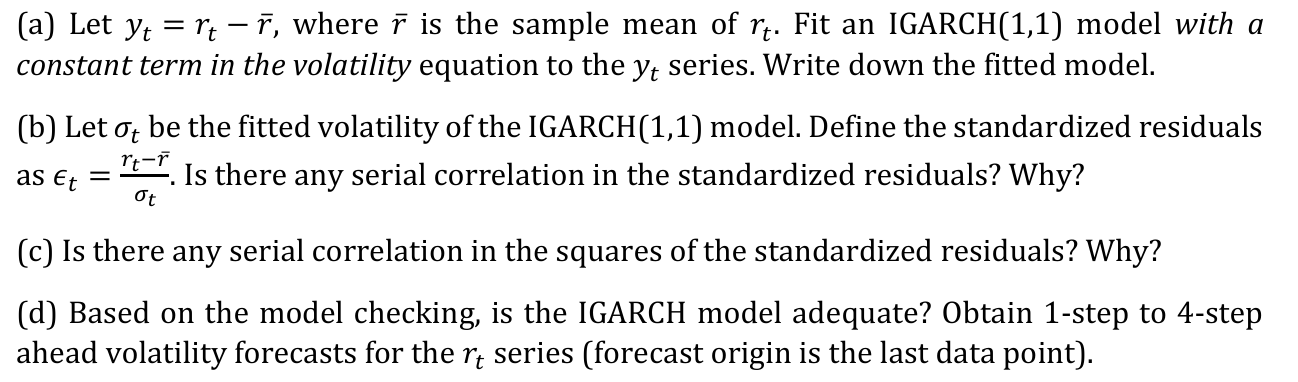

In [33]:
a = read.table("d-amzn3dx0914.txt", header = T)
a = a[,2:3]
a$date = ymd(a$date)
a = xts(a,a$date)
a$date =NULL
storage.mode(a) = "numeric"
a = 100*log(1+a$amzn) #Converting to log returns and multiplying 100
head(a)
mean(a)
a$y = a$amzn-mean(a$amzn)
a$amzn = NULL
head(a)
tail(a)
str(a)
dim(a)
t.test(a) #Mean = 0

                 amzn
2009-01-02  5.8327397
2009-01-05 -0.5534286
2009-01-06  5.9252387
2009-01-07 -2.0430284
2009-01-08  1.6937743
2009-01-09 -2.9290818

[1] 0.1192311

                    y
2009-01-02  5.7135086
2009-01-05 -0.6726597
2009-01-06  5.8060075
2009-01-07 -2.1622595
2009-01-08  1.5745432
2009-01-09 -3.0483129

                    y
2014-12-23 -0.2024657
2014-12-24 -1.1876181
2014-12-26  1.8608355
2014-12-29  0.8306433
2014-12-30 -0.6783915
2014-12-31 -0.1031324

An xts object on 2009-01-02 / 2014-12-31 containing: 
  Data:    double [1510, 1]
  Columns: y
  Index:   Date [1510] (TZ: "UTC")


[1] 1510    1

Warning message in tstat + c(-cint, cint):
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead."
Warning message in cint * stderr:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead."



	One Sample t-test

data:  a
t = -3.8684e-16, df = 1509, p-value = 1
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.1152314  0.1152314
sample estimates:
    mean of x 
-2.272527e-17 


In [34]:
source("Igarch.R")
mod3=Igarch(a$y,volcnt = T) ## estimates constant as well.

Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dn

Estimates:  0.001441448 0.9903559 


Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dn

Maximized log-likehood:  3371.468 

Coefficient(s):
        Estimate  Std. Error  t value Pr(>|t|)    
omega 0.00144145  0.00228800    0.630  0.52869    
beta  0.99035595  0.00270886  365.599  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Fitted Model is:
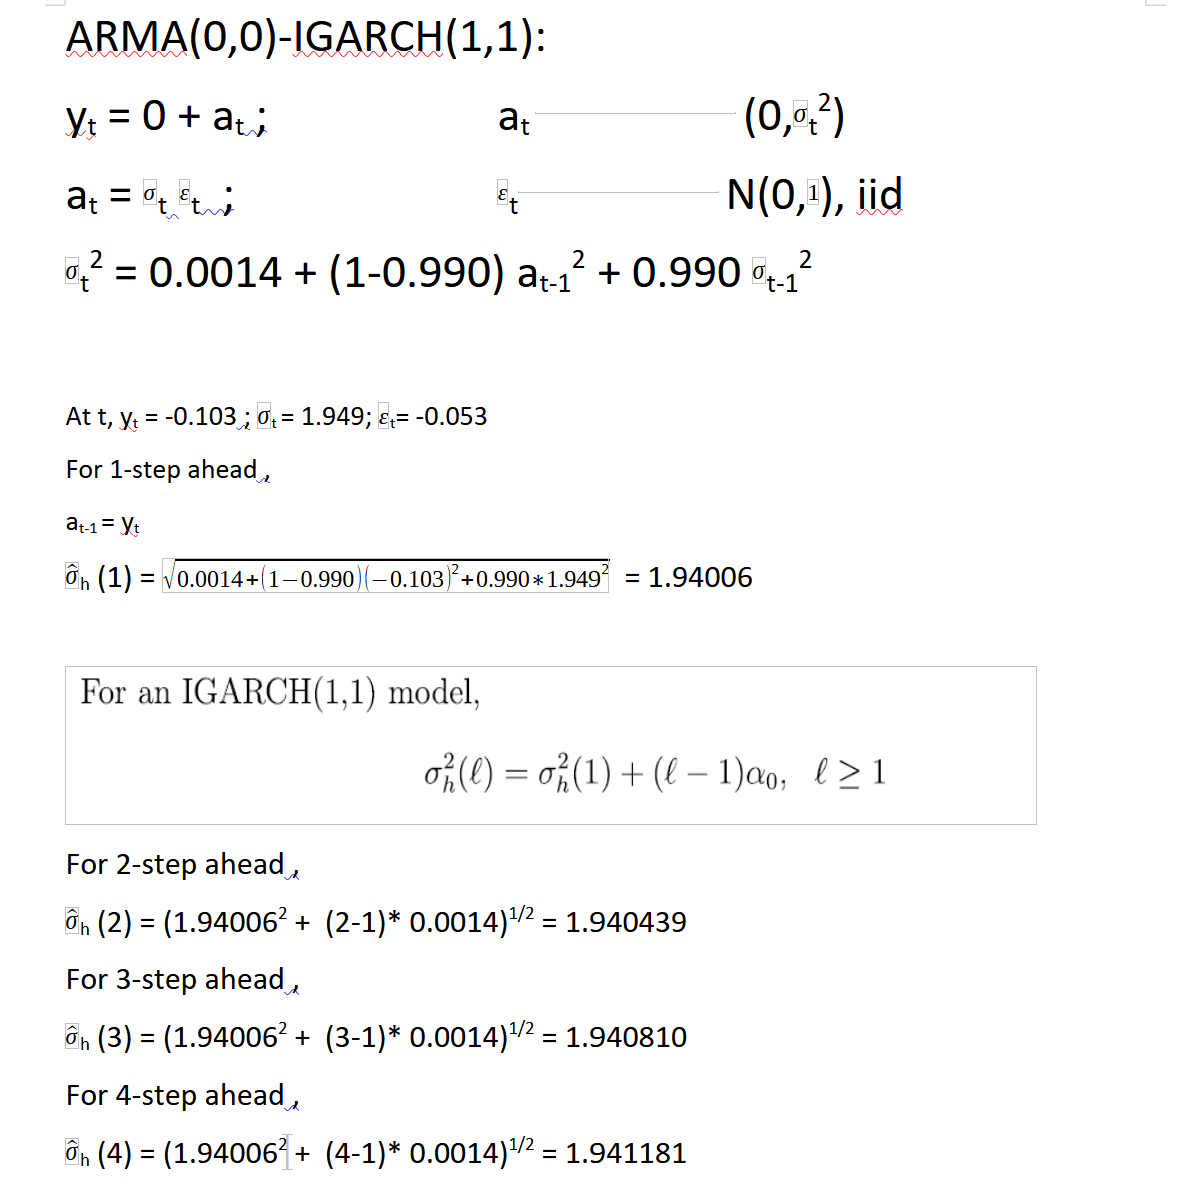

In [35]:
head(mod3$volatility)
for (i in 1:nrow(a)){
  a$sigma[i] = mod3$volatility[i]
  a$epsilon[i] = a$y[i]/a$sigma[i]
}
head(a)

A Time Series:
[1] 2.282333 2.339887 2.329823 2.387942 2.386170 2.379967

                    y    sigma    epsilon
2009-01-02  5.7135086 2.282333  2.5033630
2009-01-05 -0.6726597 2.339887 -0.2874753
2009-01-06  5.8060075 2.329823  2.4920379
2009-01-07 -2.1622595 2.387942 -0.9054908
2009-01-08  1.5745432 2.386170  0.6598623
2009-01-09 -3.0483129 2.379967 -1.2808213

**Checking Auto-Correlation for Epsilon(Standardized Residual):**


	Box-Ljung test

data:  a$epsilon
X-squared = 10.571, df = 10, p-value = 0.3919


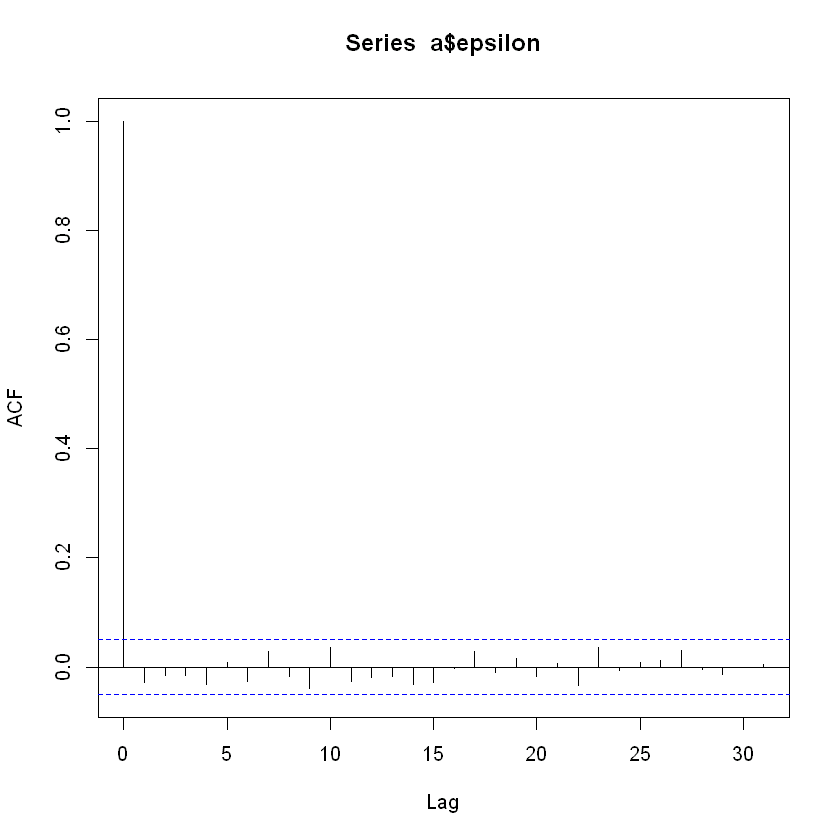

In [37]:
acf(a$epsilon)
Box.test(a$epsilon, lag = 10, type = "Ljung")


	Box-Ljung test

data:  sq_epsilon
X-squared = 3.8785, df = 10, p-value = 0.9527


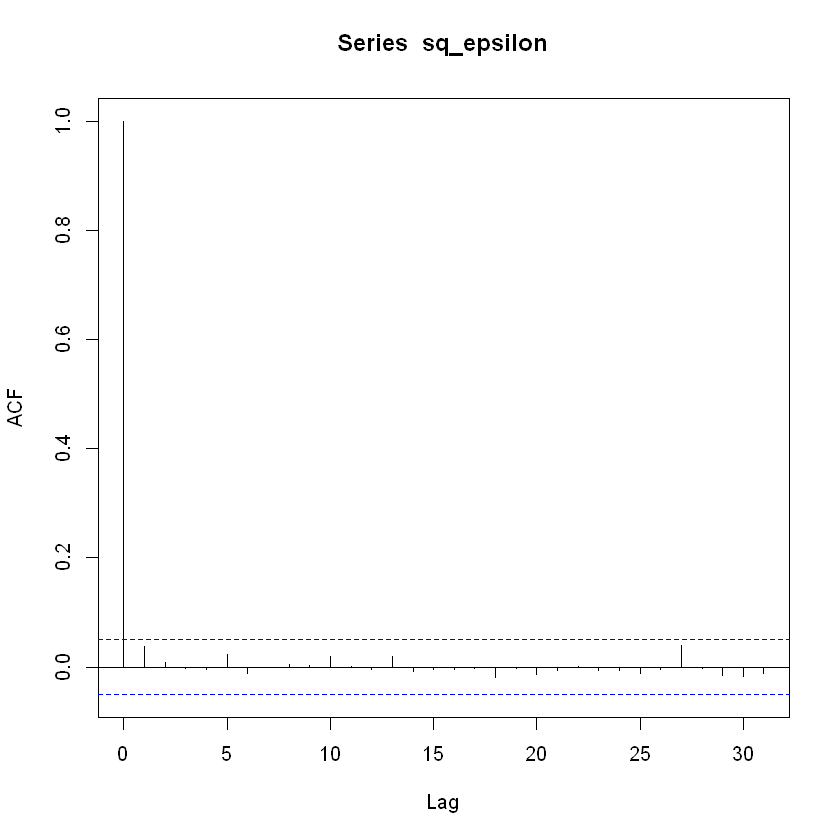

In [38]:
sq_epsilon = (a$epsilon)^2
acf(sq_epsilon)
Box.test(sq_epsilon,lag = 10,type = "Ljung")

In [40]:
#predict(mod3,5)

Based on the results of the Ljung Box test and questions 2c above shows no serial correlations in the 
square of the standardized residuals, therefore the model is adequate.  
We use the fitted model to compute the 1 step ahead prediction, after that, then we add the drift 
term.

#### 3- Consider the monthly returns of McDonald's stock from August 1966 to December 2014. 
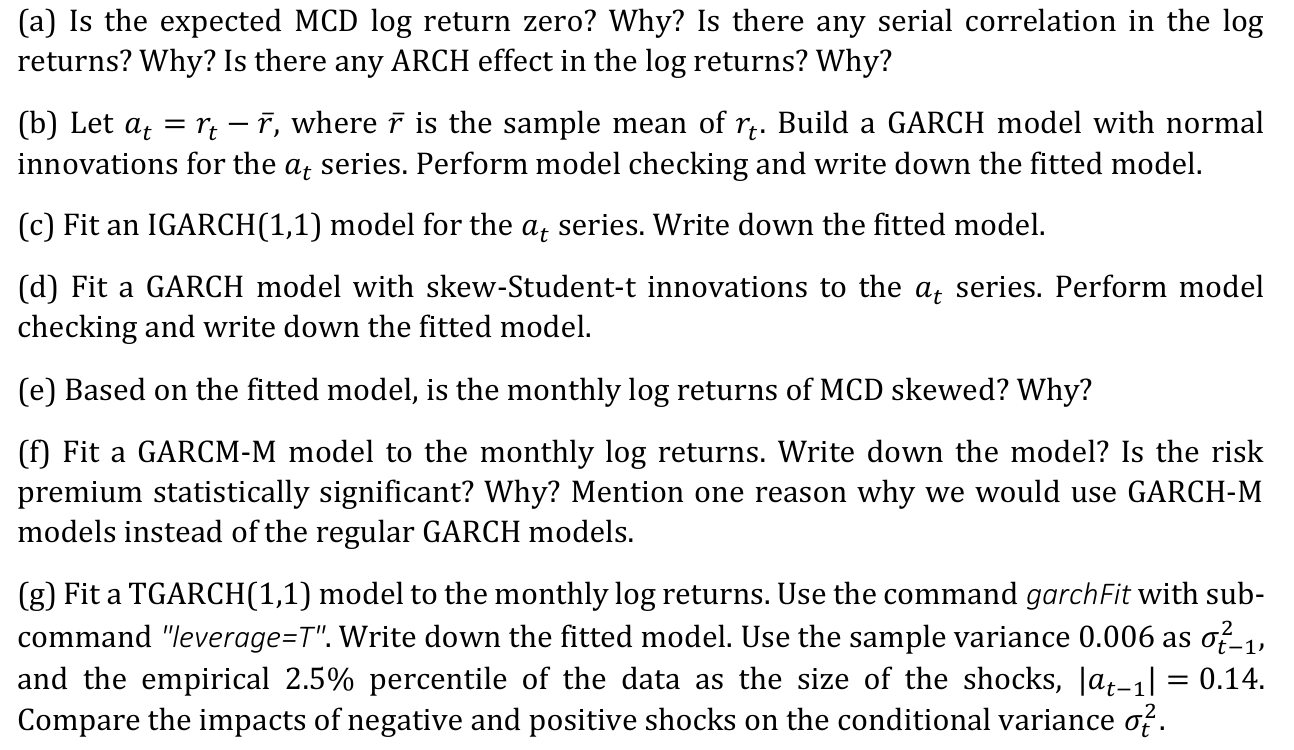

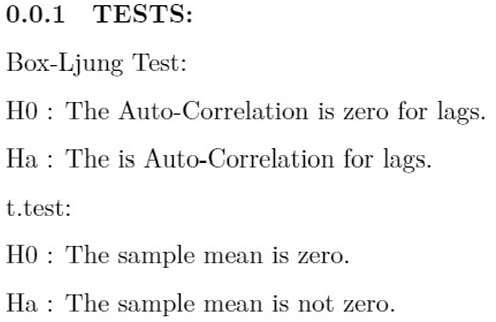

In [51]:
md = read.table("m-mcd3dx6614.txt", header = T)
md = md[,2:3]
md$date = ymd(md$date)
md = xts(md,md$date)
md$date = NULL
storage.mode(md) = "numeric"
dim(md)
head(md)
tail(md)

[1] 581   1

                 mcd
1966-08-31 -0.203390
1966-09-30 -0.106383
1966-10-31 -0.047619
1966-11-30  0.018750
1966-12-30  0.386503
1967-01-31  0.212389

                 mcd
2014-07-31 -0.061346
2014-08-29 -0.000317
2014-09-30  0.011630
2014-10-31 -0.011391
2014-11-28  0.041929
2014-12-31 -0.032125

In [52]:
md = log(1+md$mcd) #Converting to log returns
head(md)

                   mcd
1966-08-31 -0.22739005
1966-09-30 -0.11247801
1966-10-31 -0.04879011
1966-11-30  0.01857639
1966-12-30  0.32678475
1967-01-31  0.19259279

In [53]:
t.test(md)

Warning message in tstat + c(-cint, cint):
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead."
Warning message in cint * stderr:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead."



	One Sample t-test

data:  md
t = 4.3532, df = 580, p-value = 1.586e-05
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.007509528 0.019856397
sample estimates:
 mean of x 
0.01368296 


for the t-test, P-vale <0.05, so we reject null hypothesis. Hence, mean of log returns is not zero. 

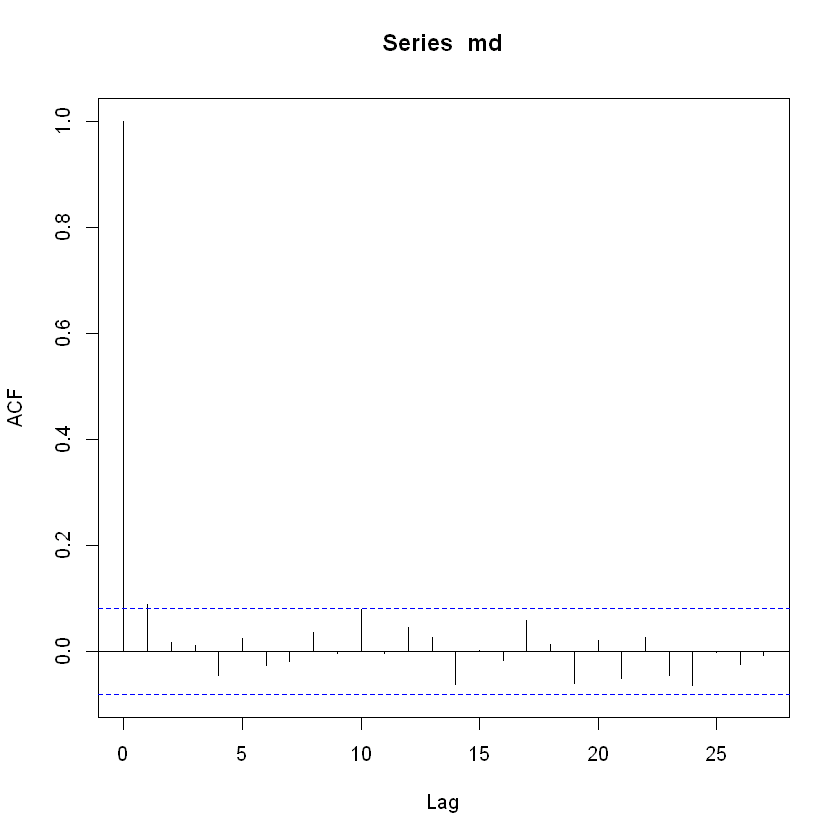

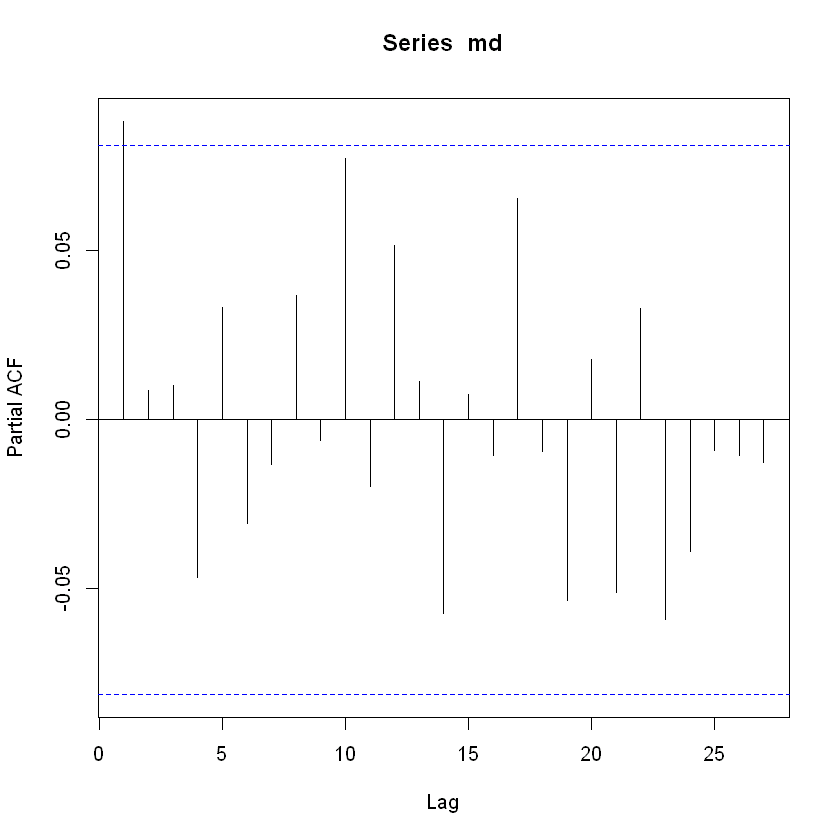

In [54]:
acf(md)
pacf(md)

In [55]:
Box.test(md,lag = 12, type ="Ljung")


	Box-Ljung test

data:  md
X-squared = 12.693, df = 12, p-value = 0.3918


There seems to be a spike at lag-1 for both ACF & PACF plots. But according to Box Test, we get p-value > 0.05. So we fail to reject Null Hypothesis. Hence, there is no serial correlation for log returns. 

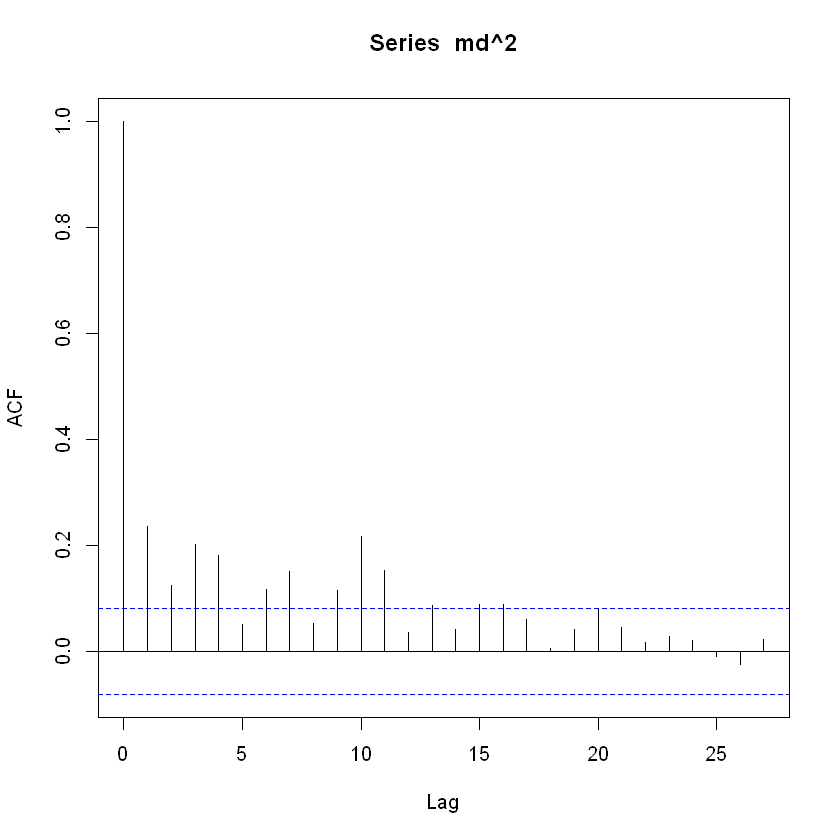

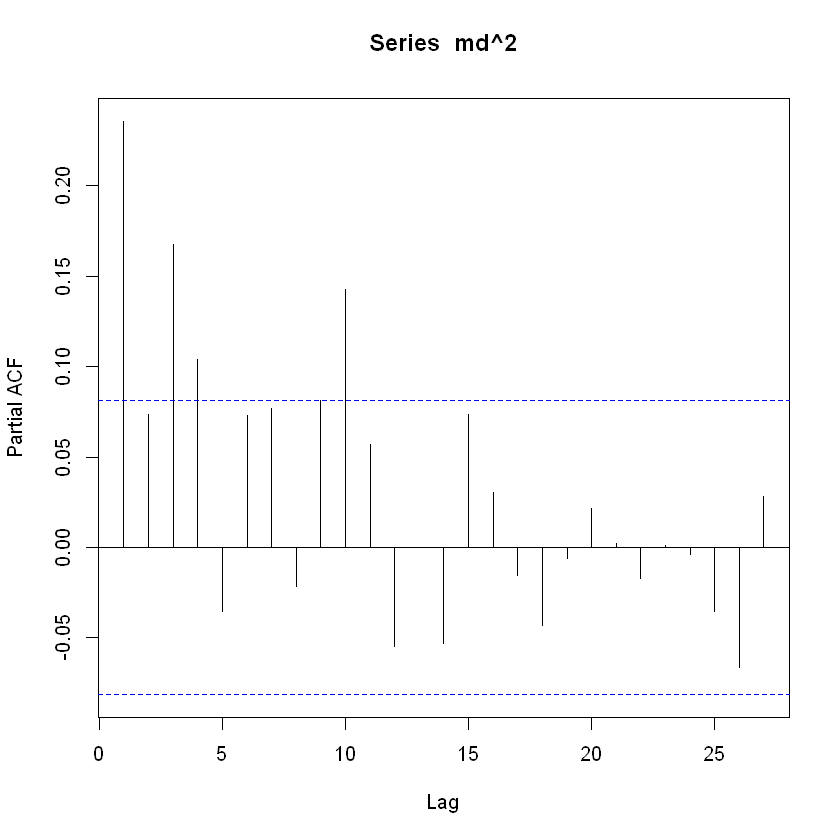

In [56]:
acf(md^2)
pacf(md^2)

In [57]:
Box.test(md^2,lag = 12, type ="Ljung")


	Box-Ljung test

data:  md^2
X-squared = 159.51, df = 12, p-value < 2.2e-16


According to Box test, p-value<0.05, we can reject null hypothesis. Hence, There is serial auto correlation for squared value of log returns. There is ARCH Effect. This can be verified with ACF & PACF plots too. 

In [59]:
md$at= md$mcd-mean(md$mcd)
head(md)

                   mcd           at
1966-08-31 -0.22739005 -0.241073017
1966-09-30 -0.11247801 -0.126160970
1966-10-31 -0.04879011 -0.062473077
1966-11-30  0.01857639  0.004893423
1966-12-30  0.32678475  0.313101787
1967-01-31  0.19259279  0.178909831

### Fitting GARCH(1,1)

In [60]:
spec1 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                   mean.model = list(armaOrder = c(0, 0)))

mod1 = ugarchfit(data = md$at, spec = spec1)
mod1


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000000    0.002405   0.0000   1.0000
omega   0.000006    0.000004   1.4259   0.1539
alpha1  0.052608    0.007409   7.1002   0.0000
beta1   0.900672    0.017468  51.5617   0.0000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000000    0.004582   0.0000 1.000000
omega   0.000006    0.000005   1.1160 0.264424
alpha1  0.052608    0.020898   2.5173 0.011824
beta1   0.900672    0.044012  20.4641 0.000000

LogLikelihood : 647.8159 

Information Criteria
------------------------------------
                    
Akaike       -2.2162
Bayes        -2.1862
Shibata      -2.2163
Hannan-Quinn -2.2045

Weig

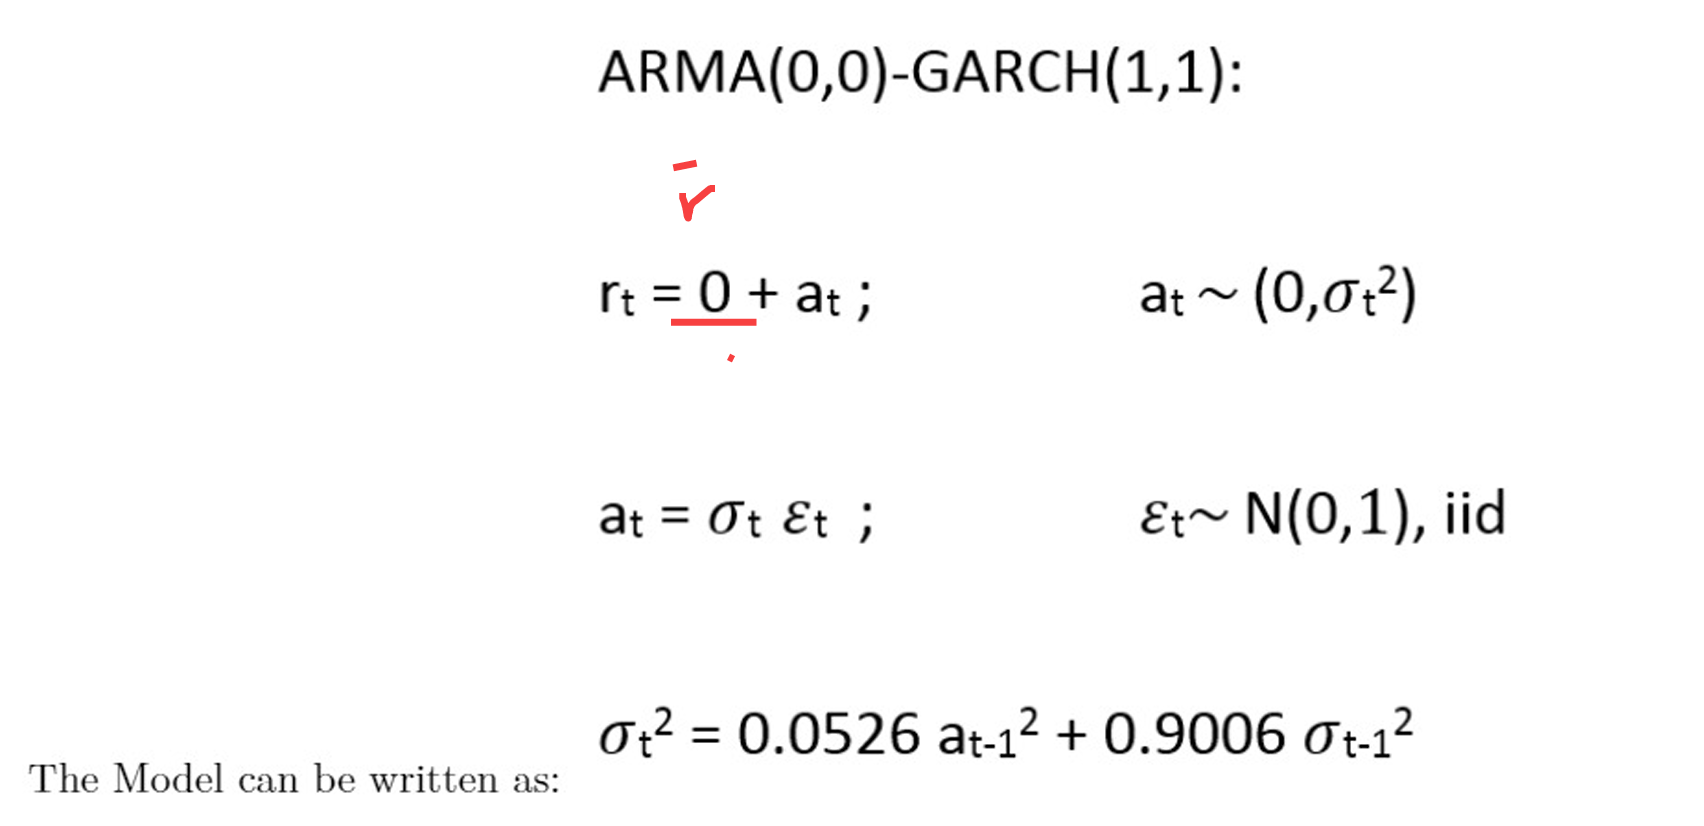

#### Model Checking

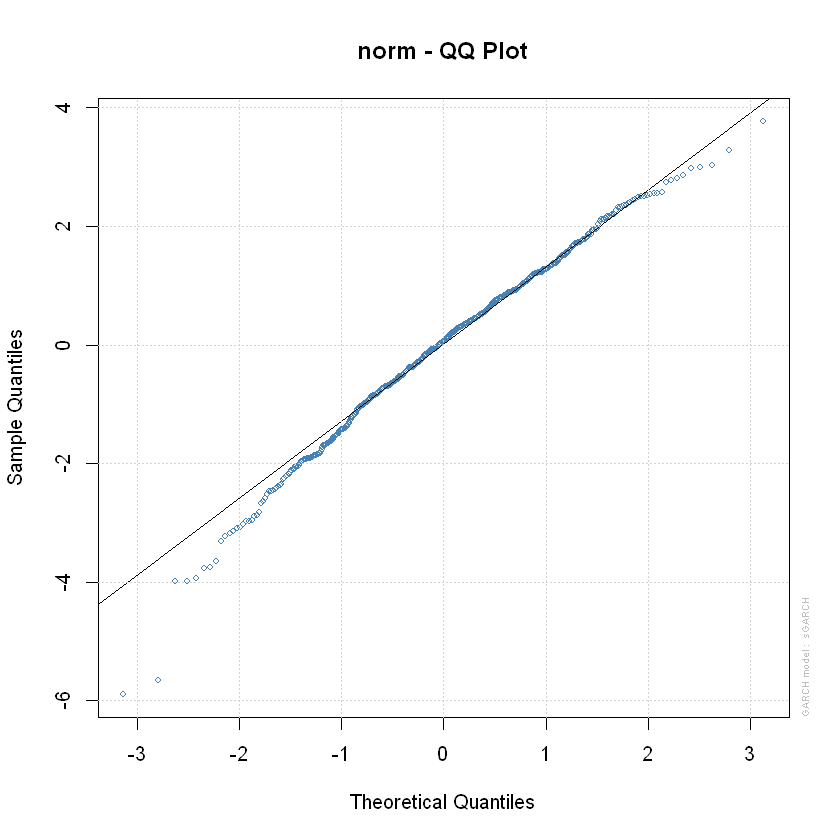

In [61]:
plot (mod1,which = 9)

The QQ-plot shows residuals are not following normal distribution at higher and lower values. This means we have fat tails. 

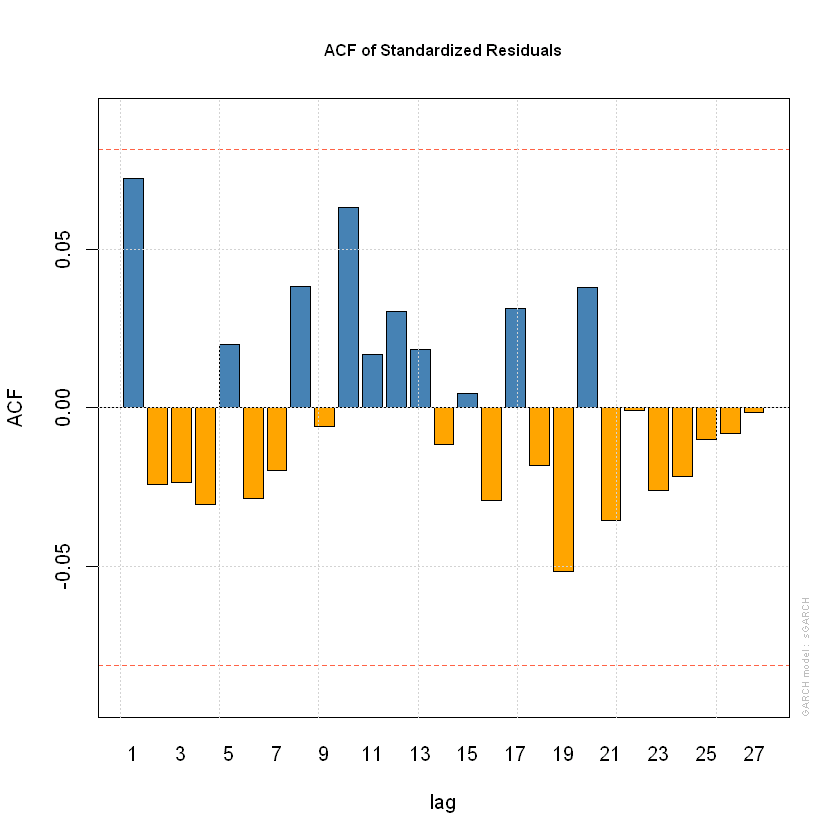

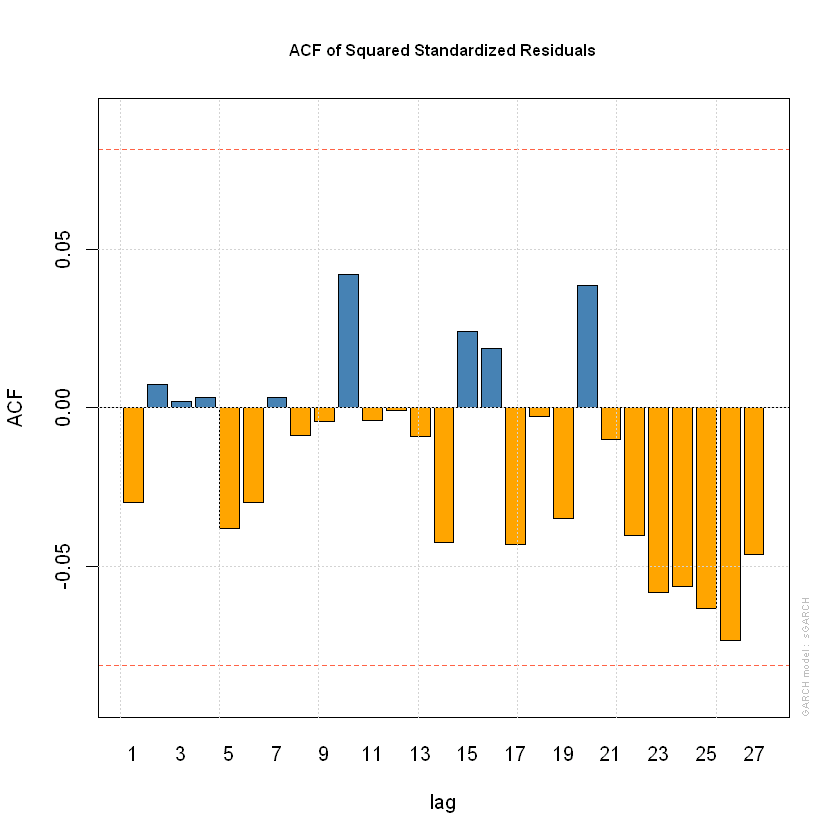

In [62]:
plot(mod1, which =10)
plot(mod1, which =11)

Looking at Box test of standardized resuluals and squared stardardized residuals, p > 0.05, we fail to reject null hypothesis. Hence, Standardized residuals have no Auto-correlation. This can be verified with ACF & PACF plots. This model looks adequate but can be improved. May be we should assume residuals to follow different distribution than normal.  

In [64]:
source ("Igarch.R")
mod2 = Igarch(md$at)

Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dn

Estimates:  0.9264447 


Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""
Warning message in dnorm(x = z/hh):
"Incompatible methods ("Ops.xts", "Ops.ts") for "/""


Maximized log-likehood:  -727.0127 

Coefficient(s):
      Estimate  Std. Error  t value   Pr(>|t|)    
beta  0.926445    0.015650  59.1979 < 2.22e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


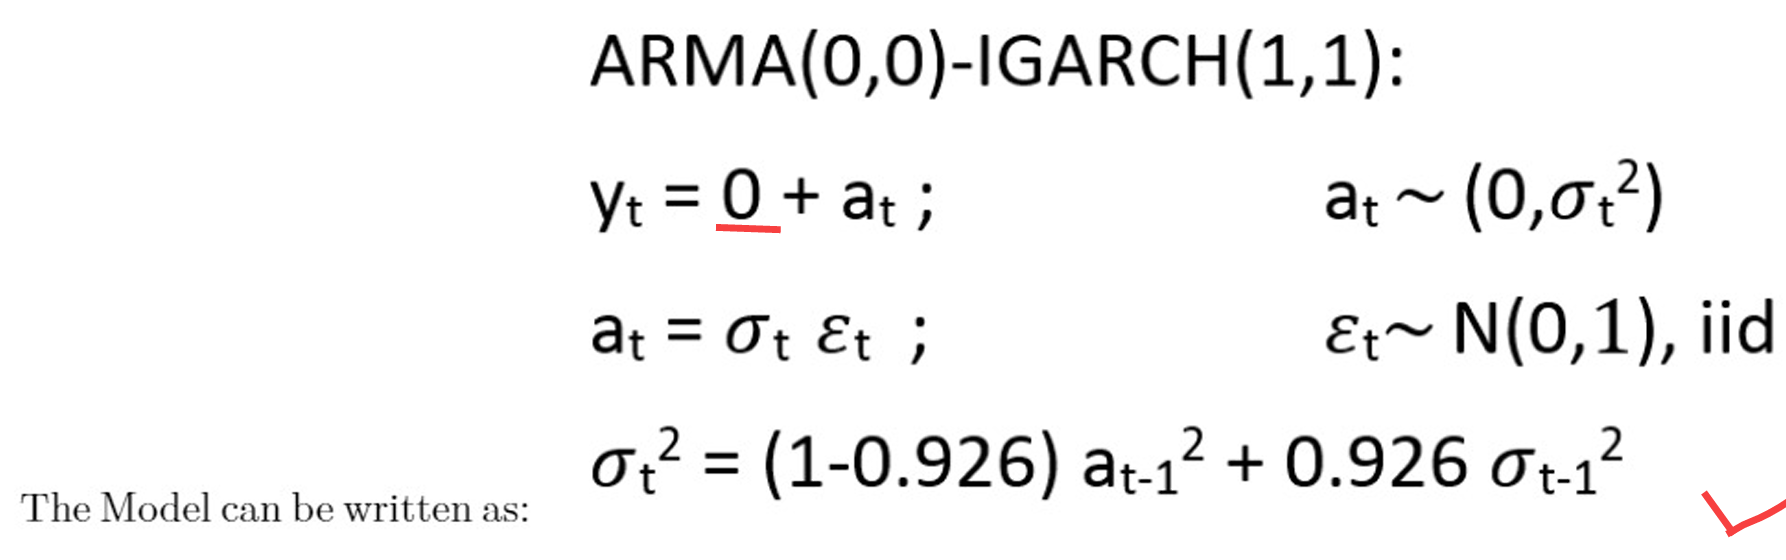

### Fitting GARCH model with skew student-t innovations

In [65]:
spec3 = ugarchspec(mean.model = list(armaOrder = c(0, 0)),
                   variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                   distribution.model = "sstd")

mod3 = ugarchfit(data = md$at, spec = spec3)
mod3


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000000    0.002489   0.0000  1.00000
omega   0.000006    0.000005   1.2479  0.21207
alpha1  0.052347    0.003205  16.3322  0.00000
beta1   0.900603    0.012020  74.9249  0.00000
skew    0.973734    0.037798  25.7612  0.00000
shape   4.066787    0.194134  20.9484  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000000    0.004275   0.0000 1.000000
omega   0.000006    0.000002   2.3573 0.018408
alpha1  0.052347    0.005825   8.9868 0.000000
beta1   0.900603    0.012542  71.8066 0.000000
skew    0.973734    0.041920  23.2286 0.000000
shape   4.066787    0.091506  44.4429 0.000000

LogLike

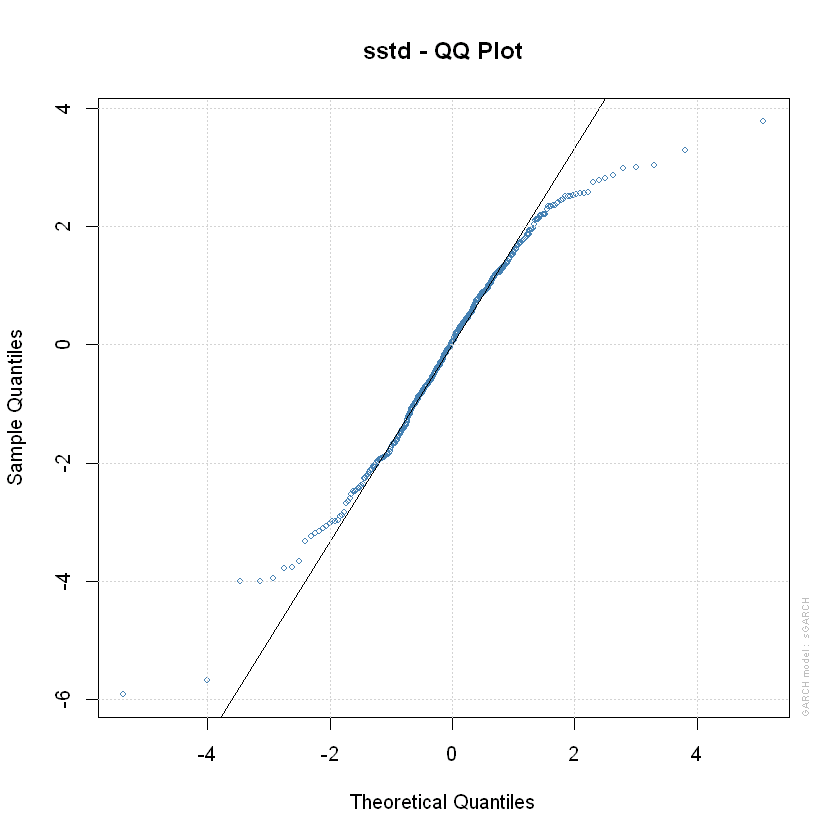

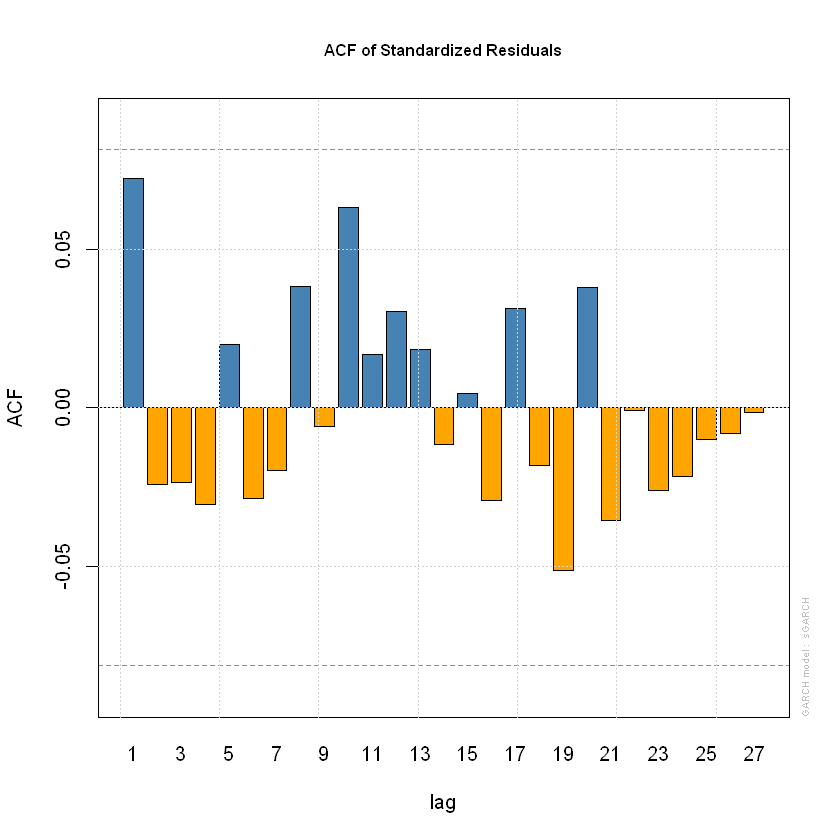

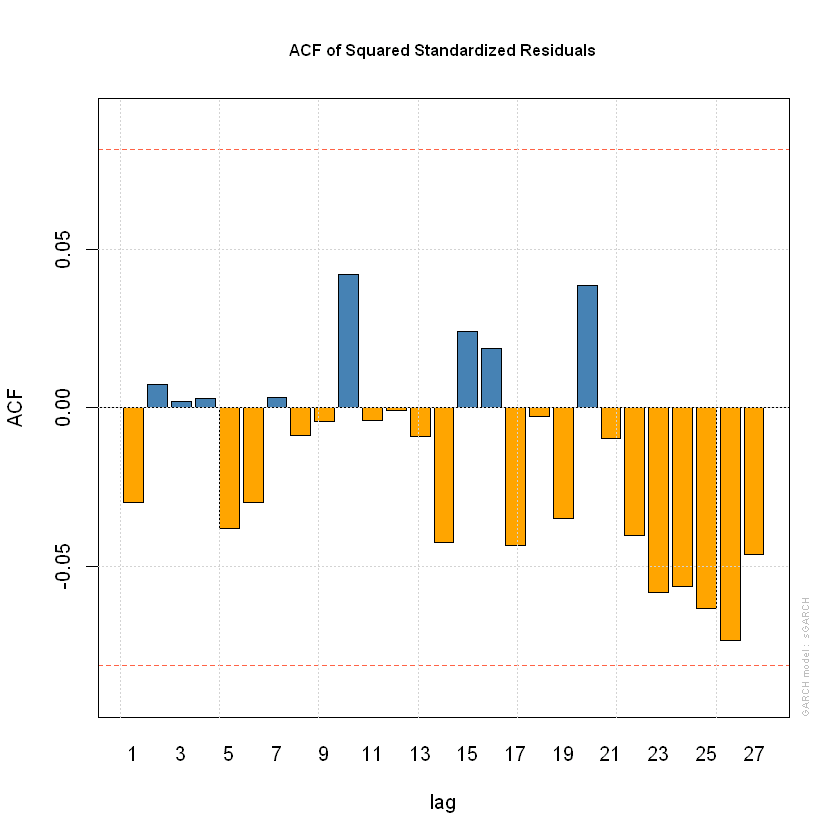

In [67]:
plot(mod3,which = 9)
plot(mod3,which = 10)
plot(mod3,which = 11)

The QQ plot does not seem to improve with swet Student-t distribution. There is no auto-correlation in residuals and squared residuals. The model looks adequate. 

In [69]:
names(mod3@fit)
coef(mod3)

[1] "hessian"         "cvar"            "var"             "sigma"          
 [5] "condH"           "z"               "LLH"             "log.likelihoods"
 [9] "residuals"       "coef"            "robust.cvar"     "A"              
[13] "B"               "scores"          "se.coef"         "tval"           
[17] "matcoef"         "robust.se.coef"  "robust.tval"     "robust.matcoef" 
[21] "fitted.values"   "convergence"     "kappa"           "persistence"    
[25] "timer"           "ipars"           "solver"

mu        omega       alpha1        beta1         skew        shape 
6.047027e-17 5.762983e-06 5.234678e-02 9.006025e-01 9.737340e-01 4.066787e+00

Since skew = 0.973, it is almost equal to one. Hence, the monthly log returns of MCD does not look skewed.

#### Fitting GARCH-M

In [71]:
mp = read.table("m-mcd3dx6614.txt", header = T)
logret = log(1+mp$mcd)
head(logret)
source("garchM.R")
garchM(logret)

[1] -0.22739005 -0.11247801 -0.04879011  0.01857639  0.32678475  0.19259279

Maximized log-likehood:  729.8678 

Coefficient(s):
         Estimate  Std. Error  t value   Pr(>|t|)    
mu    4.00381e-03 4.09800e-03  0.97702 0.32856113    
gamma 1.66189e+00 8.37010e-01  1.98551 0.04708744 *  
omega 4.84945e-05 4.93842e-05  0.98199 0.32610719    
alpha 8.91997e-02 2.43178e-02  3.66808 0.00024438 ***
beta  9.02421e-01 2.69119e-02 33.53242 < 2.22e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


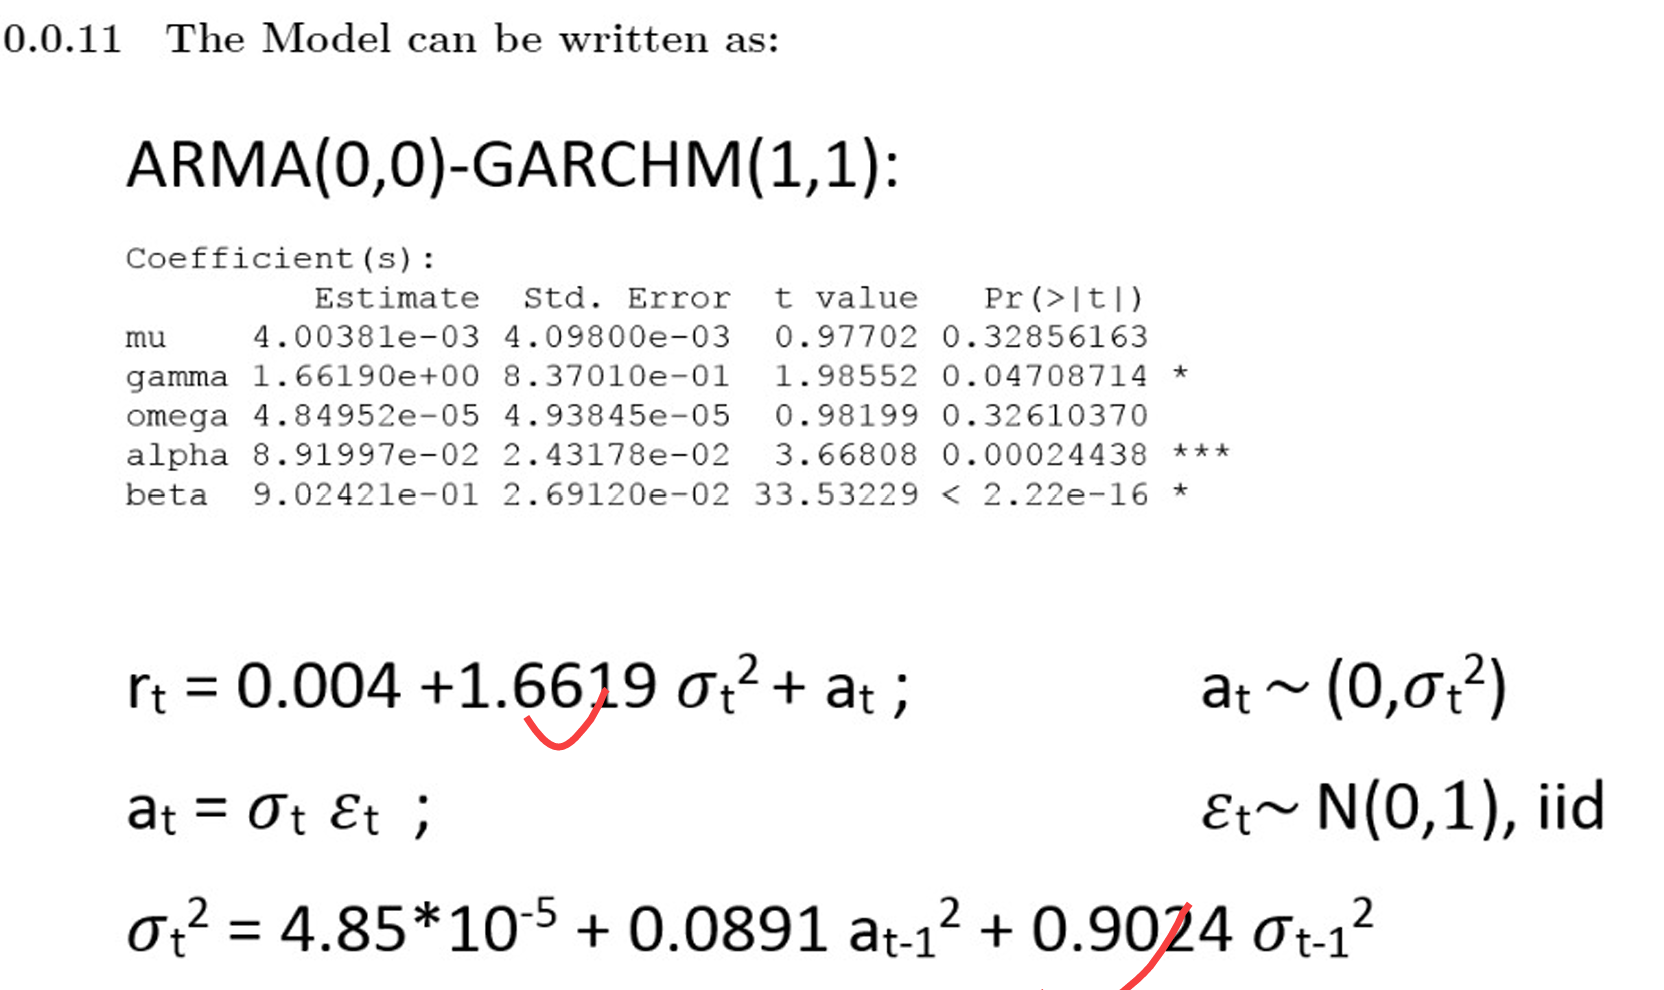

Yes, the risk premium is statistically significant. As its p-value < 0.05

GARCH-M model can be used instead of any other GARCH model when we need to consider the variance term(risk) in the mean equation. GARCH-M takes care of risk-return trade-off in its mean equation by including a risk premium term along with the square of variance. 

#### Fitting TGARCH(1,1)

In [75]:
library(fGarch)
mod5 = garchFit(~garch(1,1),data = md$at,trace=FALSE,leverage=TRUE,include.mean=FALSE)
summary(mod5)

NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")


Attaching package: 'fGarch'


The following objects are masked from 'package:PerformanceAnalytics':

    ES, VaR


The following object is masked from 'package:TTR':

    volatility





Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~garch(1, 1), data = md$at, include.mean = FALSE, 
    leverage = TRUE, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 1)
<environment: 0x0000023d60e59b68>
 [data = md$at]

Conditional Distribution:
 norm 

Coefficient(s):
     omega      alpha1      gamma1       beta1  
7.9334e-05  9.4941e-02  1.0946e-01  8.8878e-01  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
omega  7.933e-05   6.486e-05    1.223 0.221236    
alpha1 9.494e-02   2.689e-02    3.531 0.000414 ***
gamma1 1.095e-01   9.017e-02    1.214 0.224774    
beta1  8.888e-01   3.253e-02   27.320  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 729.0238    normalized:  1.254774 

Description:
 Mon Jun 23 18:28:09 2025 by user: array 


Standardised Residuals Tests:
                                 Statistic      p-Value
 Jarque-Bera Test   R    Chi^2  29.7967263

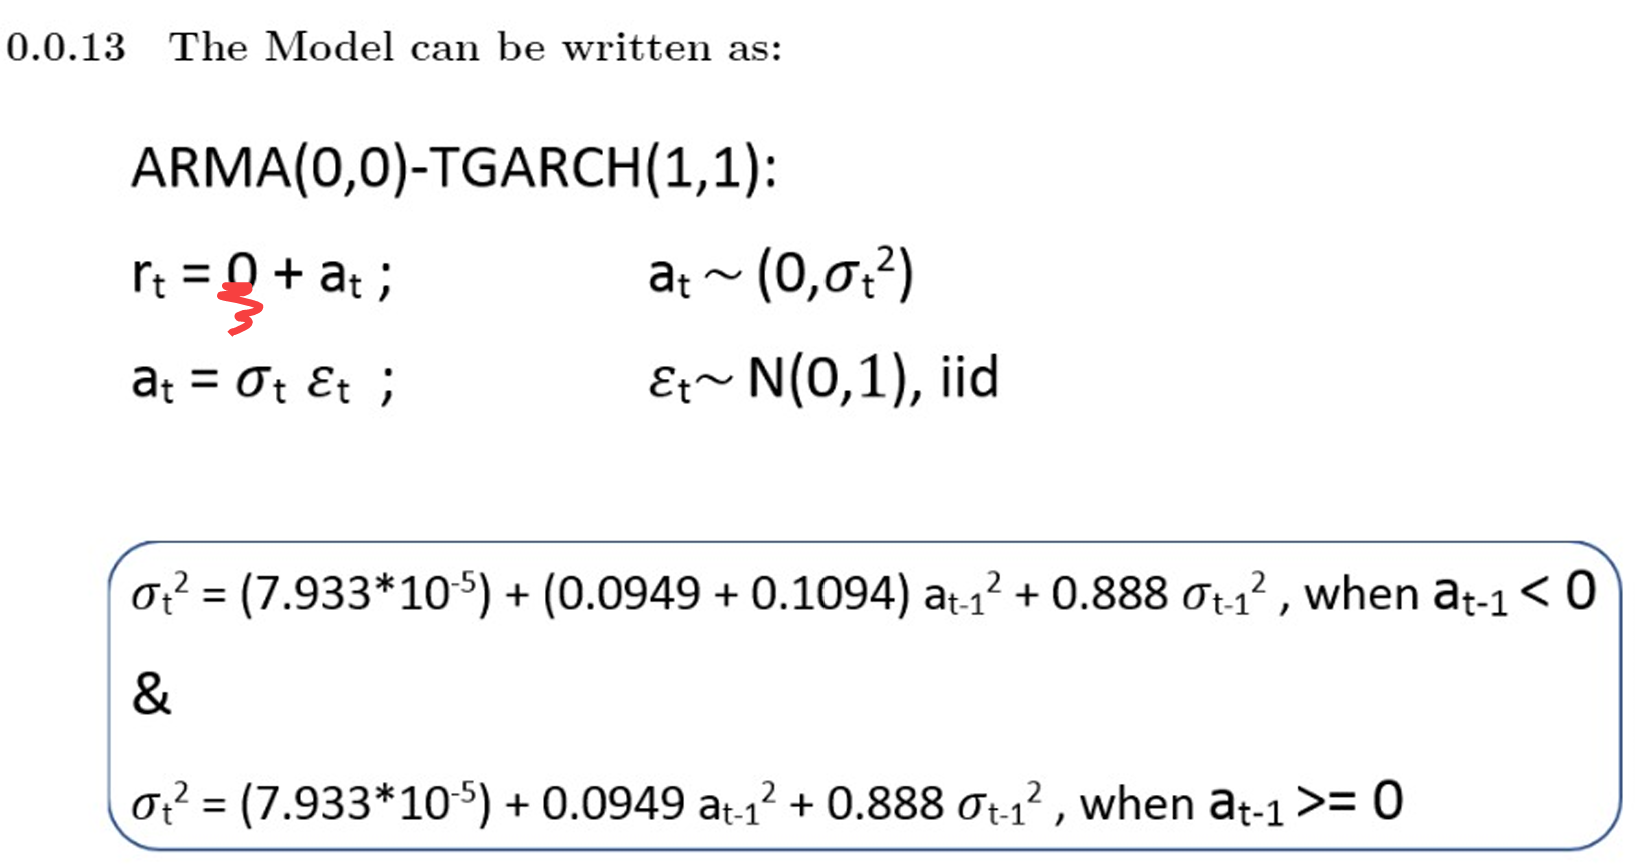

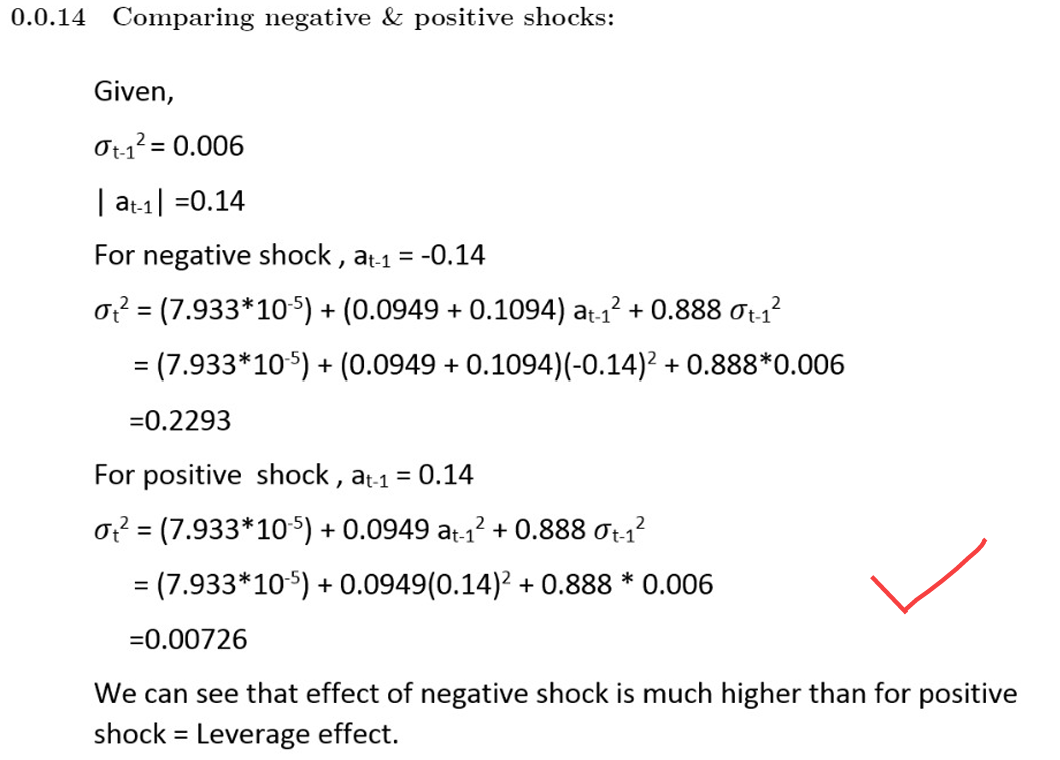

### 4.  Replication of Bollerslev (1987): A conditionally heteroskedastic time series model for speculative prices and rates of return. The Review of Economics and Statistics.
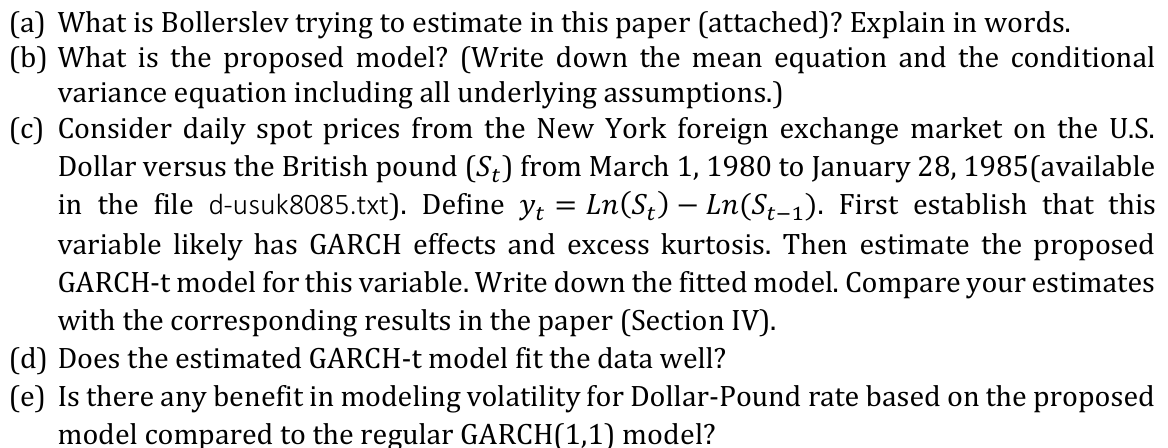


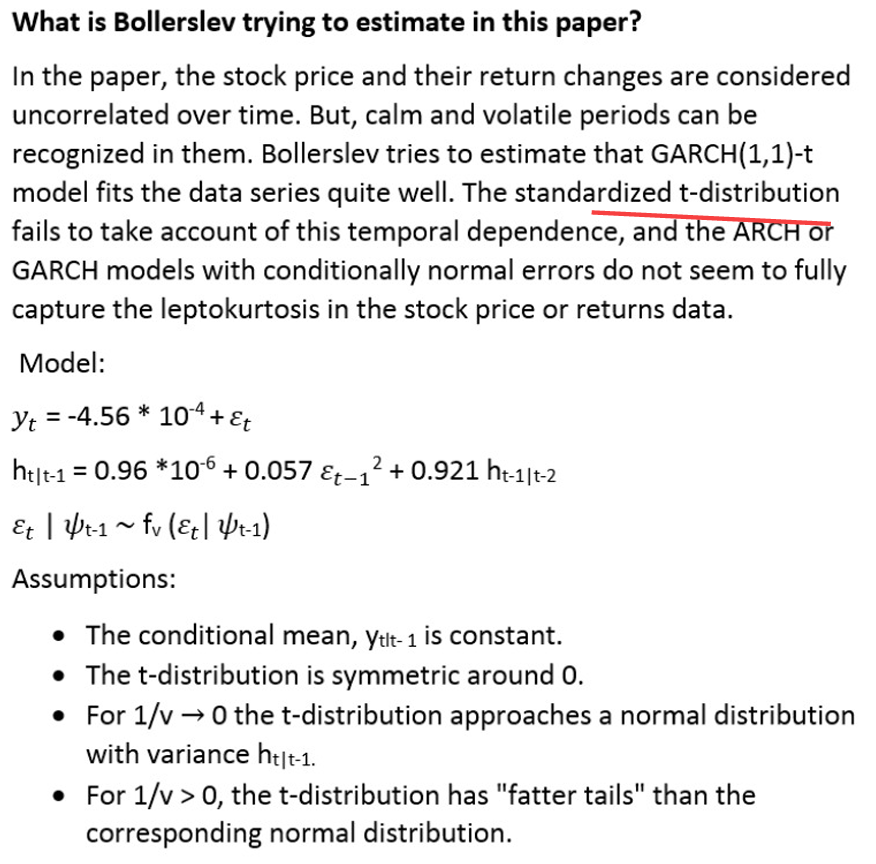

In [76]:
e = read.table("d-usuk8085.txt",header=T)
head(e)
class(e)

X1 X2.25500006098728
1 2  2.231500         
2 3  2.243500         
3 4  2.226500         
4 5  2.220499         
5 6  2.216801         
6 7  2.231000

[1] "data.frame"

In [78]:
e$X1=NULL
names(e) = c("st")
head(e)

st      
1 2.231500
2 2.243500
3 2.226500
4 2.220499
5 2.216801
6 2.231000

In [79]:
yt = diff(log(e$st)) #yt = ln(st) - ln(st-1)
head(yt)

[1]  0.005363 -0.007606 -0.002699 -0.001667  0.006385  0.002909

In [80]:
t.test(yt)


	One Sample t-test

data:  yt
t = -3.0185, df = 1242, p-value = 0.002592
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.0009263391 -0.0001965313
sample estimates:
    mean of x 
-0.0005614352 


We fail to reject null hypothsis. So, mean of the series is not zero. 

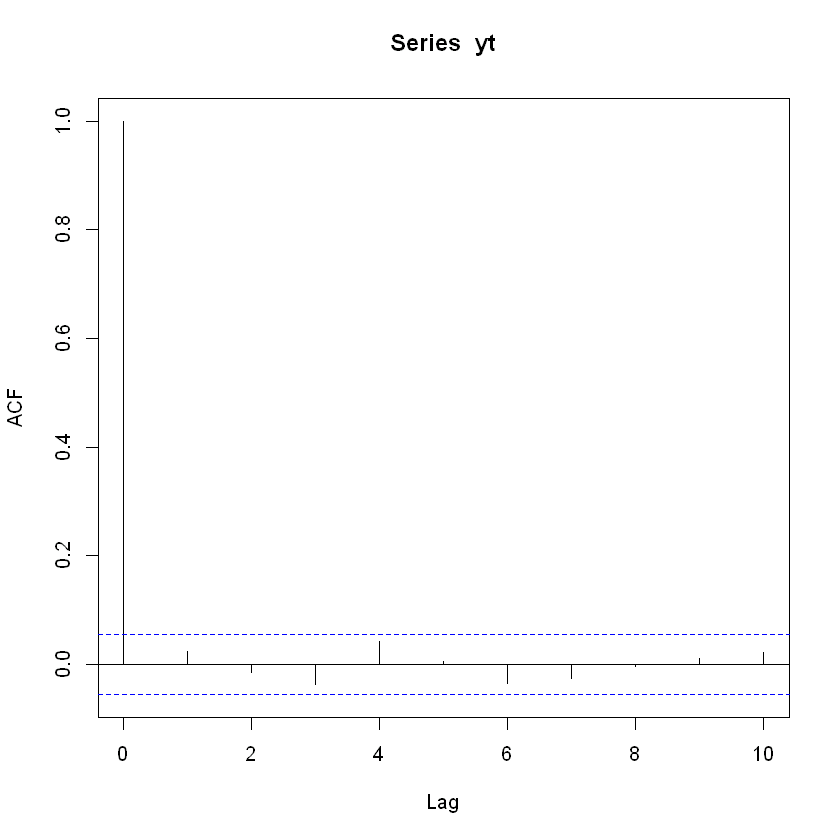

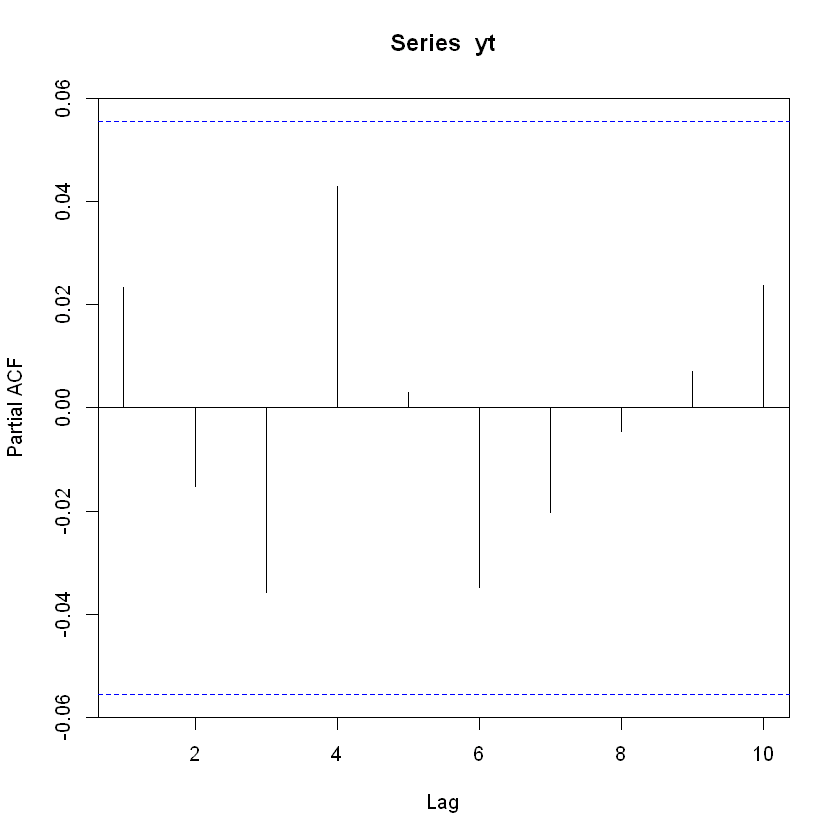

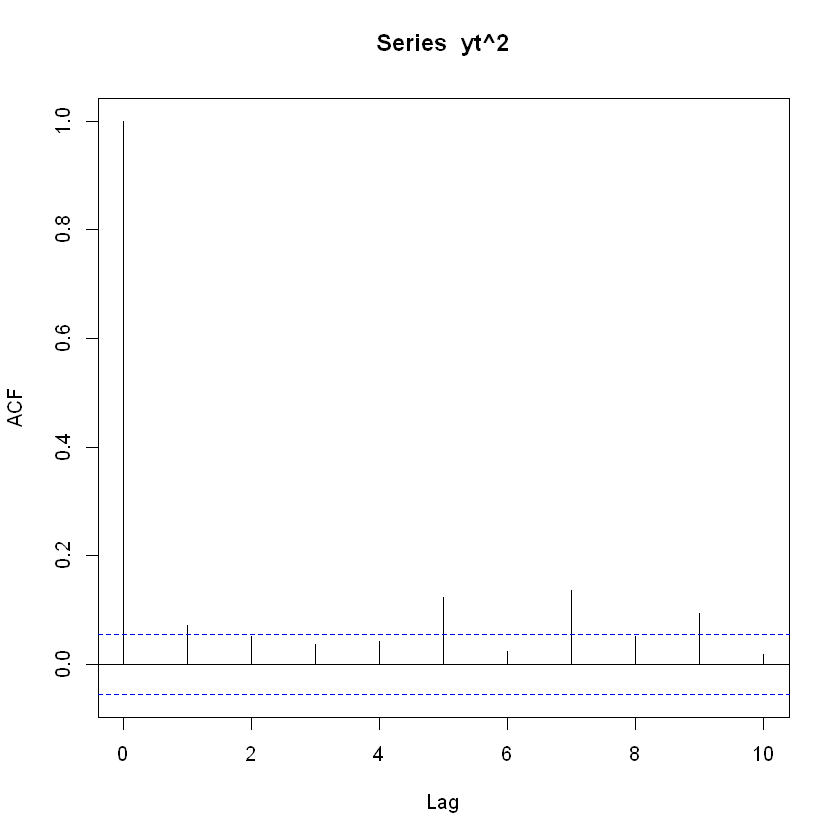

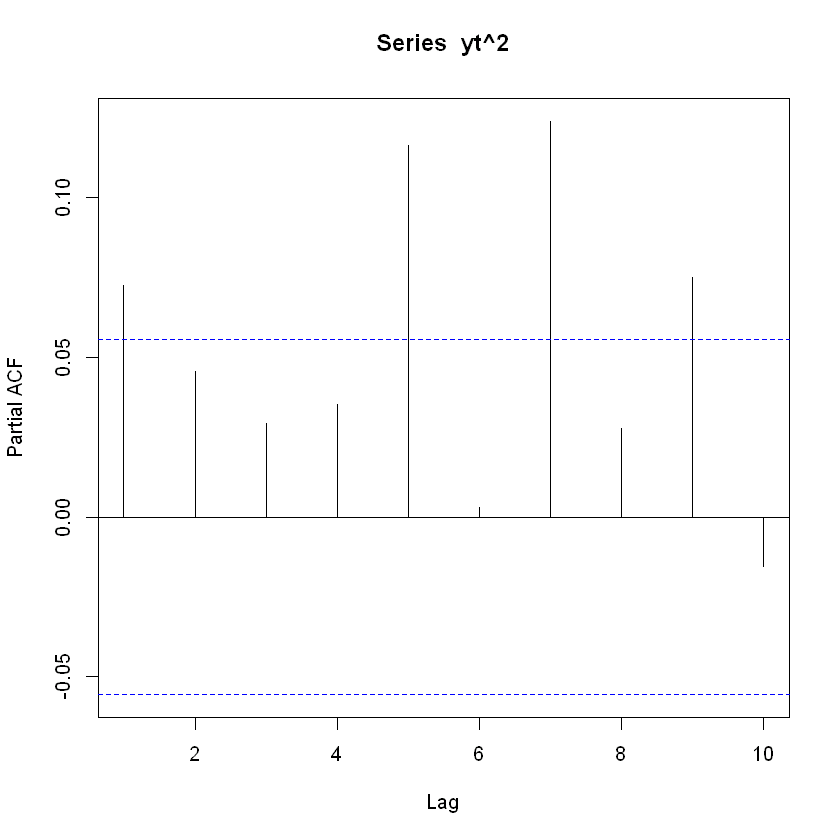

In [81]:
acf(yt,lag=10)
pacf(yt,lag=10)
acf(yt^2,lag=10)
pacf(yt^2,lag=10)

In [83]:
Box.test(yt^2,lag = 10,type='Ljung')


	Box-Ljung test

data:  yt^2
X-squared = 71.143, df = 10, p-value = 2.666e-11


We can reject null hypothesis.So, there is serial correlation in squared yt. There is GARCH effect in the data. This can be verified with ACF and PACF plots fot yt and yt^2

In [85]:
basicStats(yt)

yt         
nobs        1243.000000
NAs            0.000000
Minimum       -0.037468
Maximum        0.029205
1. Quartile   -0.004461
3. Quartile    0.003374
Mean          -0.000561
Median        -0.000327
Sum           -0.697864
SE Mean        0.000186
LCL Mean      -0.000926
UCL Mean      -0.000197
Variance       0.000043
Stdev          0.006558
Skewness      -0.275926
Kurtosis       1.817047

In [87]:
k=kurtosis(yt) #performing kurtosis test
tst=k/sqrt(24/length(yt))
tst
pv = 2*(1-pnorm(tst))  #compute two sided p-value of the test statistic.
pv

[1] 13.07664
attr(,"method")
[1] "excess"

[1] 0
attr(,"method")
[1] "excess"

p-value < 0.05. We reject null hypothesis. There is excess kurtosis.

#### Fitting GARCH-t Model(Student-t Distribution)

In [88]:
spec1 = ugarchspec(variance.model = list(model="sGARCH",garchOrder=c(1,1)),mean.model = list(armaOrder=c(0,0)),distribution.model = 'std')
mod1=ugarchfit(data = yt,spec = spec1)
mod1


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.000448    0.000165  -2.7137 0.006654
omega   0.000001    0.000000   1.6857 0.091859
alpha1  0.053412    0.009915   5.3867 0.000000
beta1   0.927960    0.011340  81.8315 0.000000
shape   8.058498    1.514514   5.3208 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.000448    0.000168 -2.66364 0.007730
omega   0.000001    0.000002  0.47720 0.633217
alpha1  0.053412    0.065469  0.81583 0.414595
beta1   0.927960    0.067070 13.83567 0.000000
shape   8.058498    2.625458  3.06937 0.002145

LogLikelihood : 4545.092 

Information Criteria
------------------------------------
                 

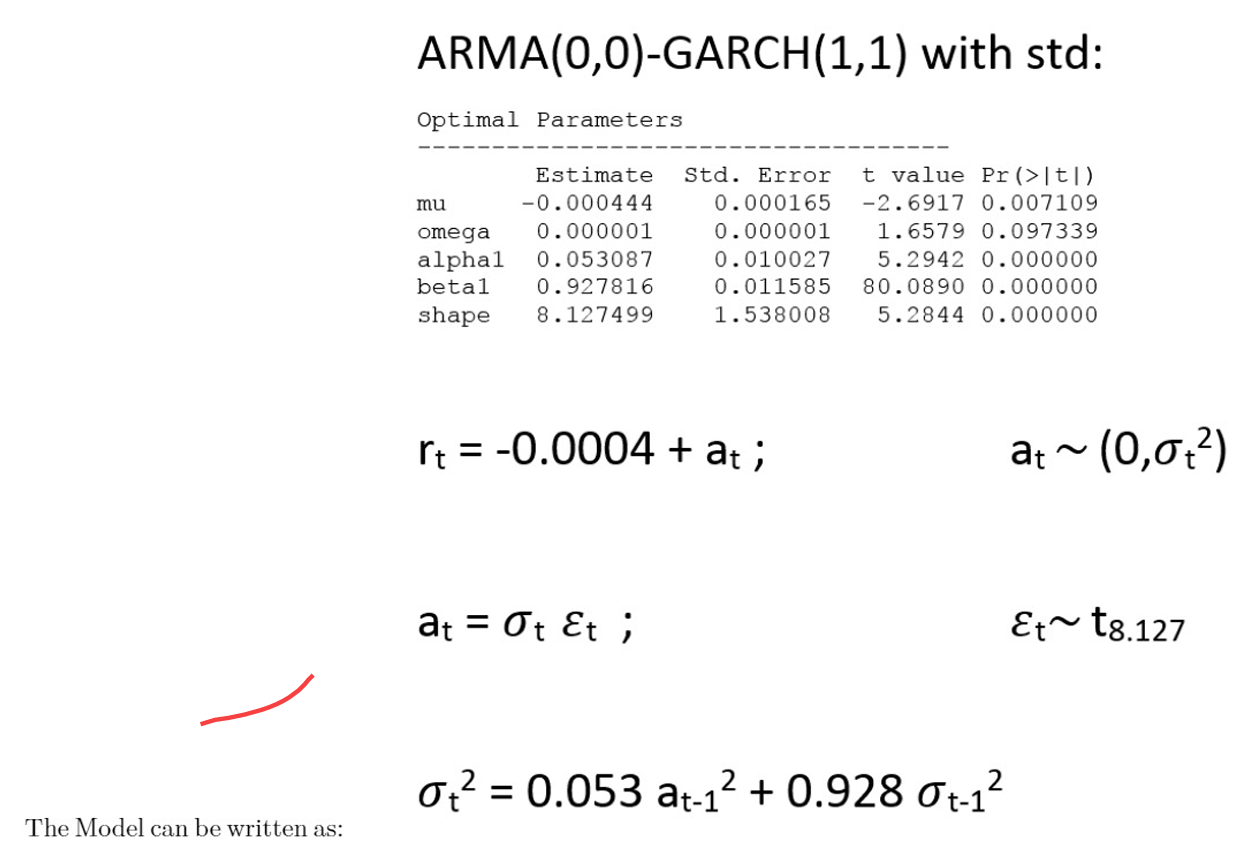

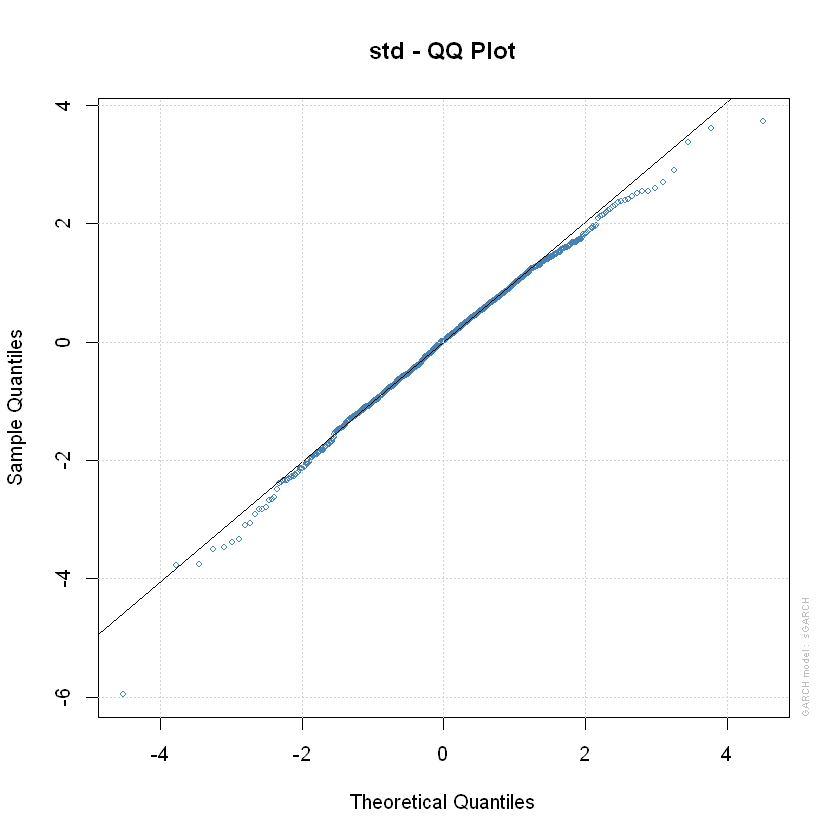

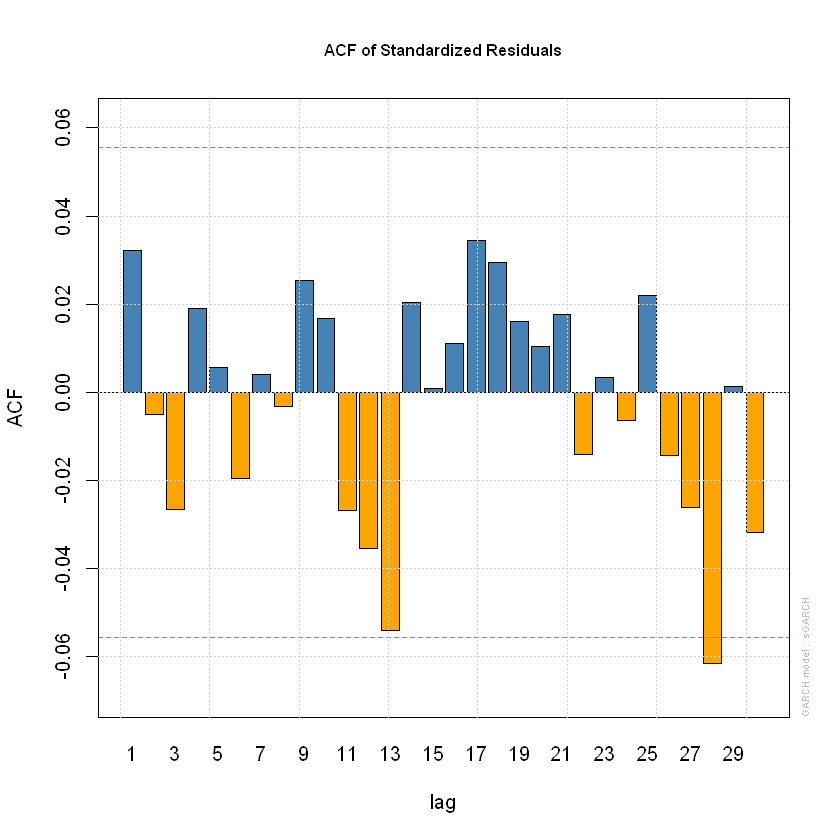

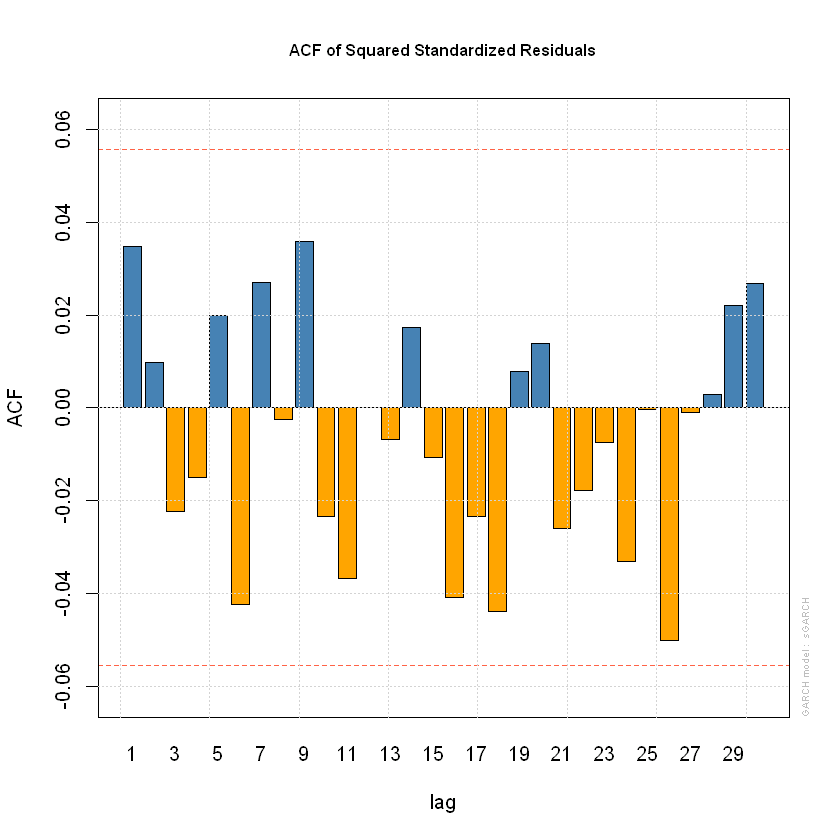

In [89]:
plot(mod1,which=9)
plot(mod1,which=10)
plot(mod1,which=11)

Looking at QQ-plot, the data fits well for most part but not for extreme values.

Looking at ACF plot of Standardized residuals and squared residuals, we can say that there is no significant Auto-correlation for them. 
There is no single or double order dependence.

Most of the data from the stock market prices to exchange rates have skewness and leptokurtosis in them. As stated in reserach papaer, even though the unconditional error distribution corresponding to the normal GARCH models with conditionally normal errors are lepokurtic, they do not completely account for the leptokurtosis. The GARCH-t models account for them , so foreign exchange volatility modelling would prefer GARCH-t models to the normal GARCH models. 

#### 5.  Consider the log return of daily exchange rate (file d-exusuk-0615.txt) between UK Pounds and U.S. Dollars from January 4, 2006 to March 20, 2015.

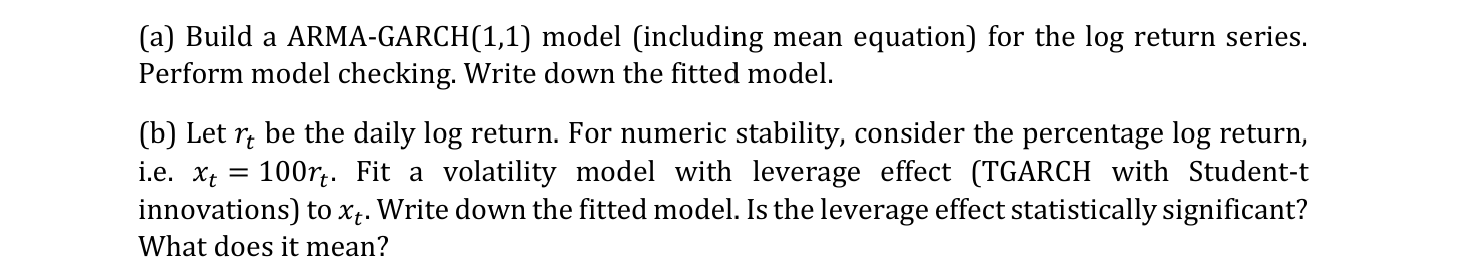

In [90]:
x = read.table("d-exusuk-0615.txt",header = T)
head(x)

Year Mon Day Value 
1 2006 1    3  1.7404
2 2006 1    4  1.7588
3 2006 1    5  1.7566
4 2006 1    6  1.7697
5 2006 1    9  1.7645
6 2006 1   10  1.7645

In [99]:
x$date = as.Date(with(x,paste(Year,Mon,Day,sep="-")),"%Y-%m-%d")

x= xts(x$Value, x$date)  #Converting to XTS
dim(x)
head(x)

[1] 2316    1

             [,1]
2006-01-03 1.7404
2006-01-04 1.7588
2006-01-05 1.7566
2006-01-06 1.7697
2006-01-09 1.7645
2006-01-10 1.7645

In [100]:
names(x) = c("Value")
tail(x)

            Value
2015-03-13 1.4755
2015-03-16 1.4800
2015-03-17 1.4744
2015-03-18 1.4686
2015-03-19 1.4729
2015-03-20 1.4923

In [101]:
rt = diff(log(x$Value)) #converting to log returns
rt = rt[-1,1]
names(rt) = c("logret")
rt = as.vector(rt)
head(rt)

[1]  0.010516786 -0.001251636  0.007429918 -0.002942677  0.000000000
[6] -0.000113353

In [102]:
t.test(rt)


	One Sample t-test

data:  rt
t = -0.51168, df = 2314, p-value = 0.6089
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.0003210425  0.0001881731
sample estimates:
    mean of x 
-6.643474e-05 


p-value>0.05. We fail to reject null hypothesis. The mean of log returns is zero.

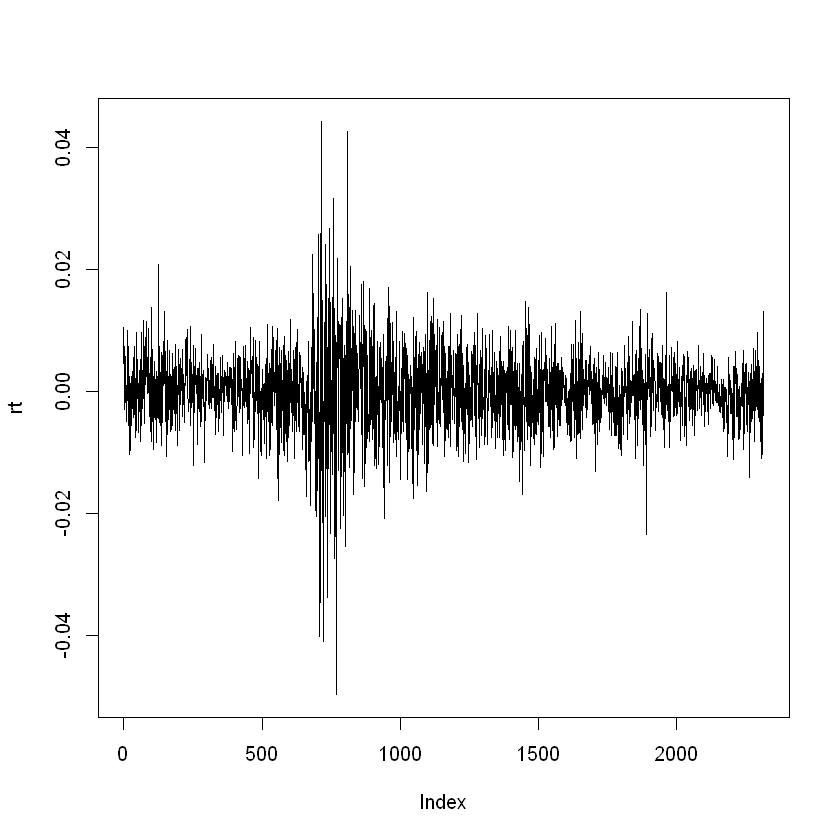

In [103]:
plot(rt,type = "l")

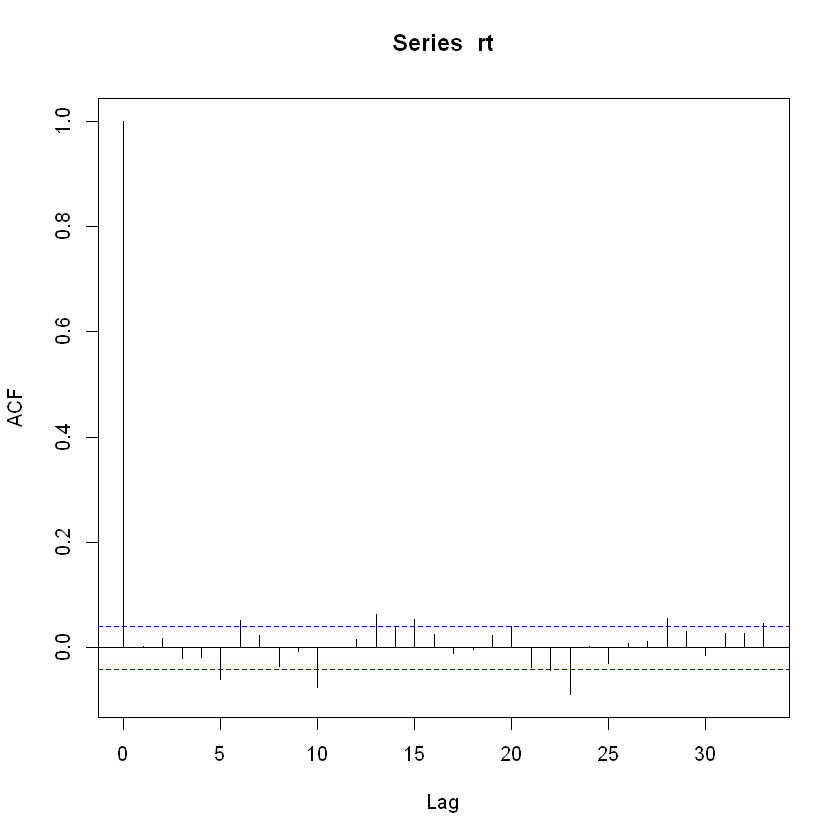

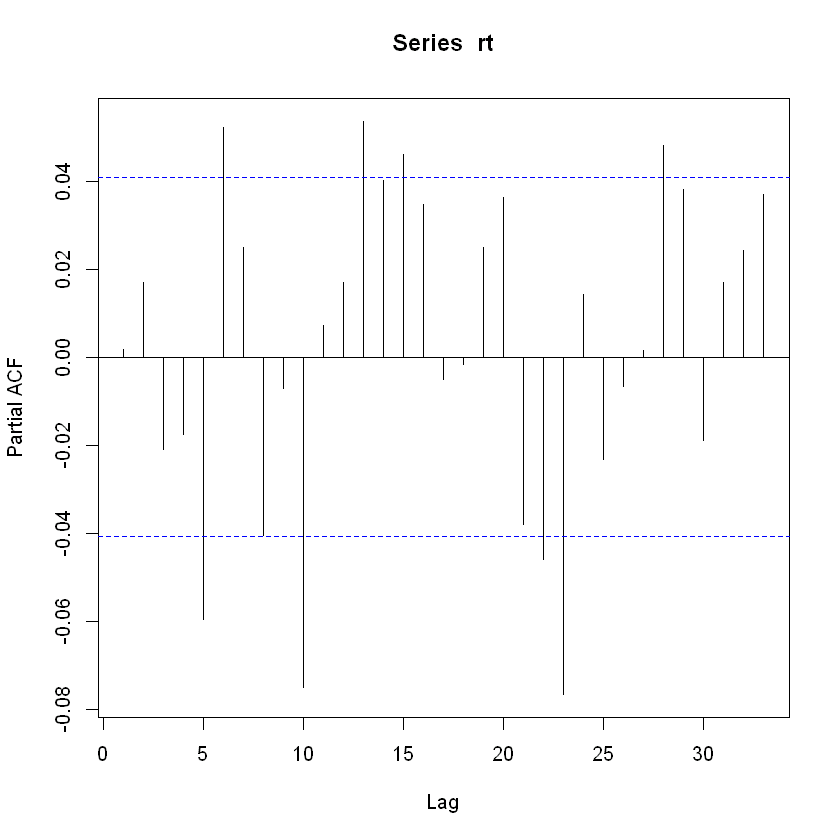

In [104]:
acf(rt)
pacf(rt)

In [105]:
Box.test(rt, lag= 10, type = "Ljung")


	Box-Ljung test

data:  rt
X-squared = 34.482, df = 10, p-value = 0.000153


p-value < 0.05. We reject the null hypothesis. Hence, there is Auto-correlation in the series.

In [108]:

#install.packages("tseries")
library(tseries)

Installing package into 'C:/Users/array/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'tseries' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\array\AppData\Local\Temp\Rtmp4efNwe\downloaded_packages


In [109]:
adf.test(rt)

Warning message in adf.test(rt):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  rt
Dickey-Fuller = -12.321, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


H0 = Series has unit root.
Ha = Series does not have unit root.
p-value < 0.05. We can reject H0. So, Series is stationary.

In [112]:
#install.packages('forecast')
library('forecast')
auto.arima(rt,ic = c("aicc")) #estimating optimum ARMA order

Series: rt 
ARIMA(0,0,0) with zero mean 

sigma^2 = 3.901e-05:  log likelihood = 8465.66
AIC=-16929.33   AICc=-16929.32   BIC=-16923.58

In [113]:
arm = ar(rt, method = "mle") #Estimating optimum ARMA order
arm


Call:
ar(x = rt, method = "mle")

Coefficients:
      1        2        3        4        5        6        7        8  
 0.0027   0.0179  -0.0184  -0.0150  -0.0655   0.0515   0.0238  -0.0391  
      9       10  
-0.0070  -0.0753  

Order selected 10  sigma^2 estimated as  3.841e-05

#### Fitting ARMA (10,0)

In [114]:
arma1 = Arima(rt, order = c(10,0,0),include.mean = FALSE, method = c("ML"))
arma1

Series: rt 
ARIMA(10,0,0) with zero mean 

Coefficients:
         ar1     ar2      ar3      ar4      ar5     ar6     ar7      ar8
      0.0029  0.0181  -0.0183  -0.0147  -0.0654  0.0516  0.0239  -0.0390
s.e.  0.0208  0.0207   0.0207   0.0207   0.0207  0.0207  0.0207   0.0207
          ar9     ar10
      -0.0067  -0.0752
s.e.   0.0208   0.0208

sigma^2 = 3.859e-05:  log likelihood = 8483.37
AIC=-16944.74   AICc=-16944.63   BIC=-16881.52


	Box-Ljung test

data:  arma1$residuals
X-squared = 0.22785, df = 10, p-value = 1


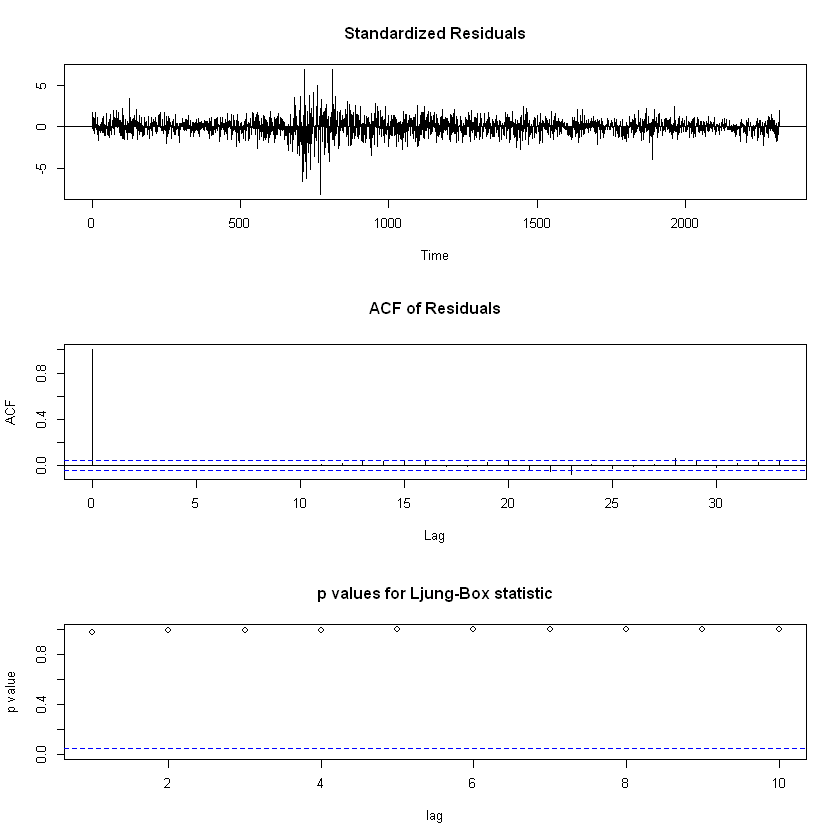

In [115]:
tsdiag(arma1)
Box.test(arma1$residuals, lag =10, type ="Ljung")

Residuals are not serially correlated and are behaving as white noise. So, our model looks adequate.

In [116]:
Box.test(arma1$residuals^2, lag =10 , type = "Ljung")


	Box-Ljung test

data:  arma1$residuals^2
X-squared = 758.85, df = 10, p-value < 2.2e-16


Looks like squared residuals are not independent. ARCH effect. 

#### Fitting ARMA(10,0)-GARCH(1,1)

In [117]:
spec1 = ugarchspec(variance.model = list(model="sGARCH",garchOrder=c(1,1)),mean.model = list(armaOrder=c(10,0)))
mod1=ugarchfit(data = rt,spec = spec1)
mod1


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(10,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000025    0.000098   0.25025 0.802394
ar1    -0.007906    0.021522  -0.36732 0.713377
ar2     0.008900    0.021429   0.41532 0.677909
ar3    -0.008298    0.021389  -0.38798 0.698032
ar4    -0.016217    0.021372  -0.75882 0.447962
ar5    -0.034183    0.021192  -1.61302 0.106740
ar6     0.063989    0.021219   3.01561 0.002565
ar7     0.005484    0.021367   0.25665 0.797447
ar8    -0.013826    0.021308  -0.64885 0.516433
ar9     0.012825    0.021198   0.60500 0.545177
ar10   -0.025176    0.021244  -1.18508 0.235985
omega   0.000000    0.000000   0.18457 0.853570
alpha1  0.042084    0.006717   6.26537 0.000000
beta1   0.956532  

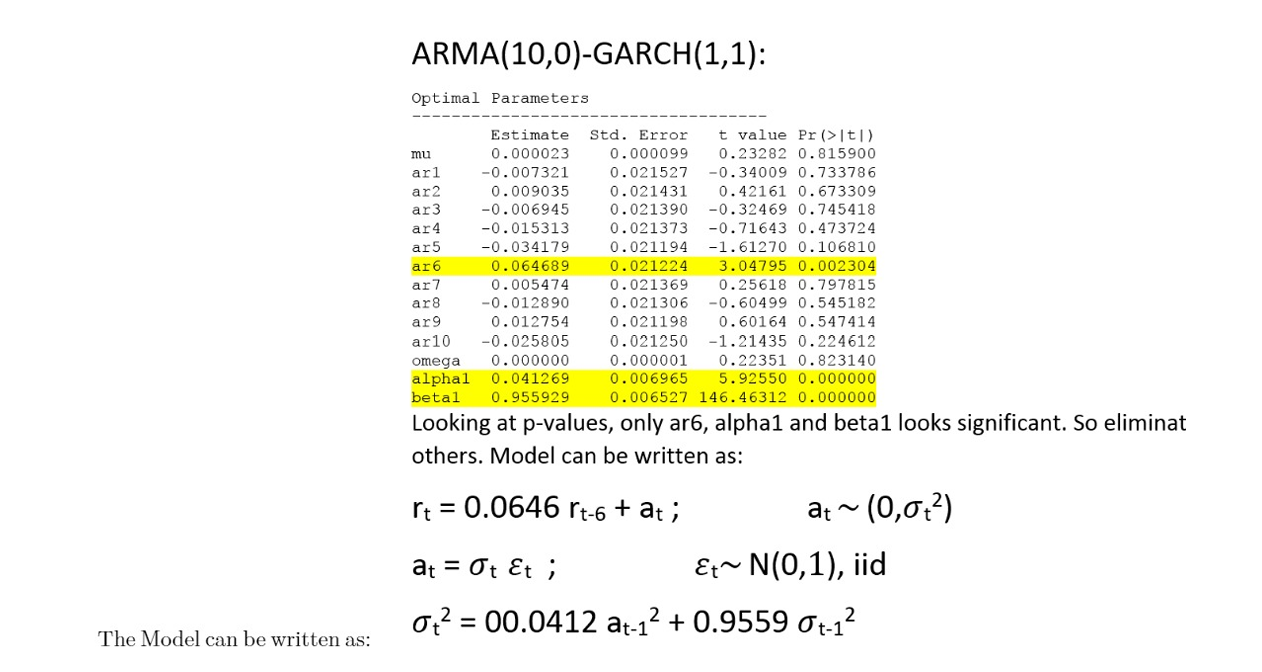

Model Checking

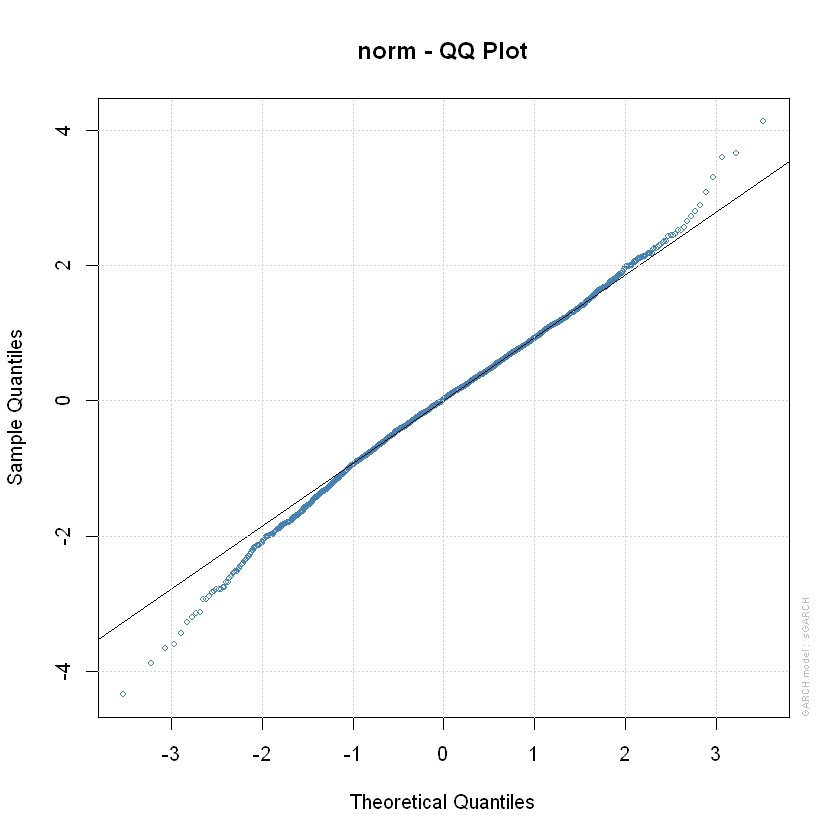

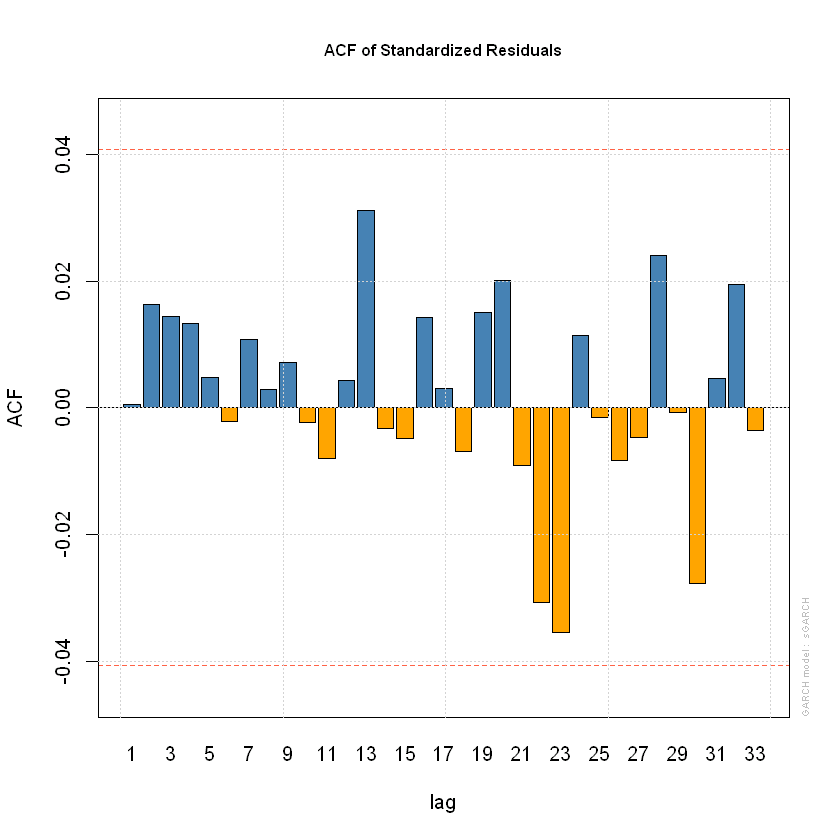

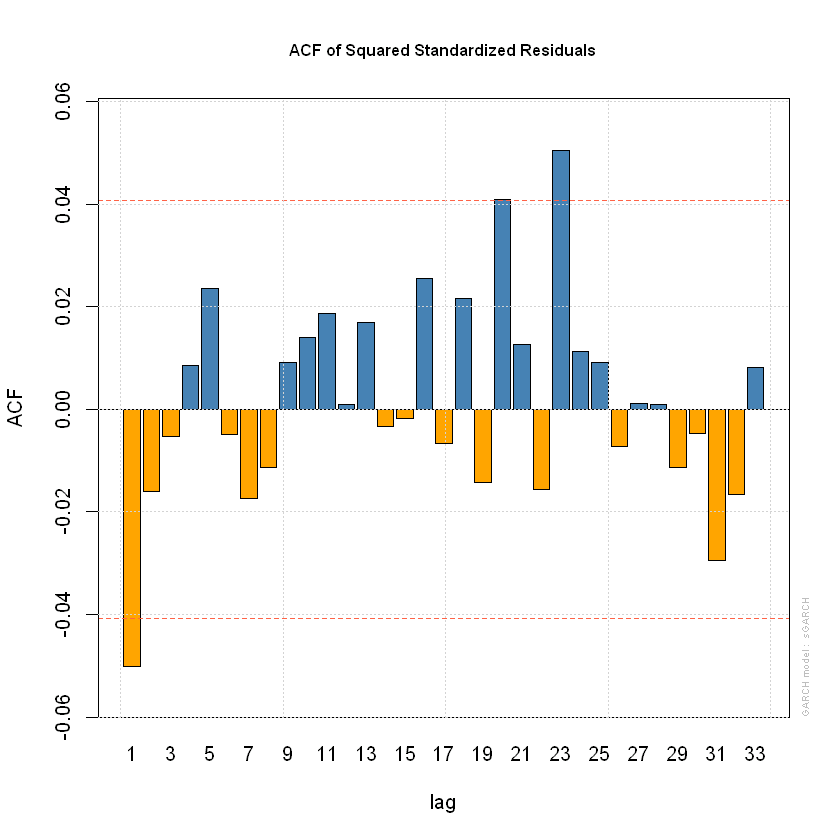

In [119]:
plot(mod1,which = 9)
plot(mod1,which = 10)
plot(mod1,which = 11)

The QQ plot shows residuals are diverging from normal distribution at extreme value.

There looks to be significant auto-correlation for squared standardized residuals at lag-1. So, Model does not look adequate.

In [122]:
xt = 100*rt
head(xt)

[1]  1.0516786 -0.1251636  0.7429918 -0.2942677  0.0000000 -0.0113353

#### Fitting a volatility model with leverage effect(TGARCH with Student-t Innovations)

In [123]:
mod2 = garchFit(~garch(1,1),data = xt ,cond.dist = "std",trace = FALSE,leverage = TRUE,include.mean = FALSE)
summary(mod2)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~garch(1, 1), data = xt, cond.dist = "std", 
    include.mean = FALSE, leverage = TRUE, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 1)
<environment: 0x0000023d58abb230>
 [data = xt]

Conditional Distribution:
 std 

Coefficient(s):
     omega      alpha1      gamma1       beta1       shape  
6.5405e-04  2.2127e-02  4.2244e-01  9.7165e-01  1.0000e+01  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
omega  6.540e-04   3.823e-04    1.711 0.087097 .  
alpha1 2.213e-02   5.848e-03    3.784 0.000154 ***
gamma1 4.224e-01   1.692e-01    2.497 0.012510 *  
beta1  9.717e-01   4.457e-03  218.015  < 2e-16 ***
shape  1.000e+01   1.728e+00    5.788 7.11e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 -1818.347    normalized:  -0.7854632 

Description:
 Mon Jun 23 19:27:55 2025 by user: array 


Standardised Residuals Tests:
        

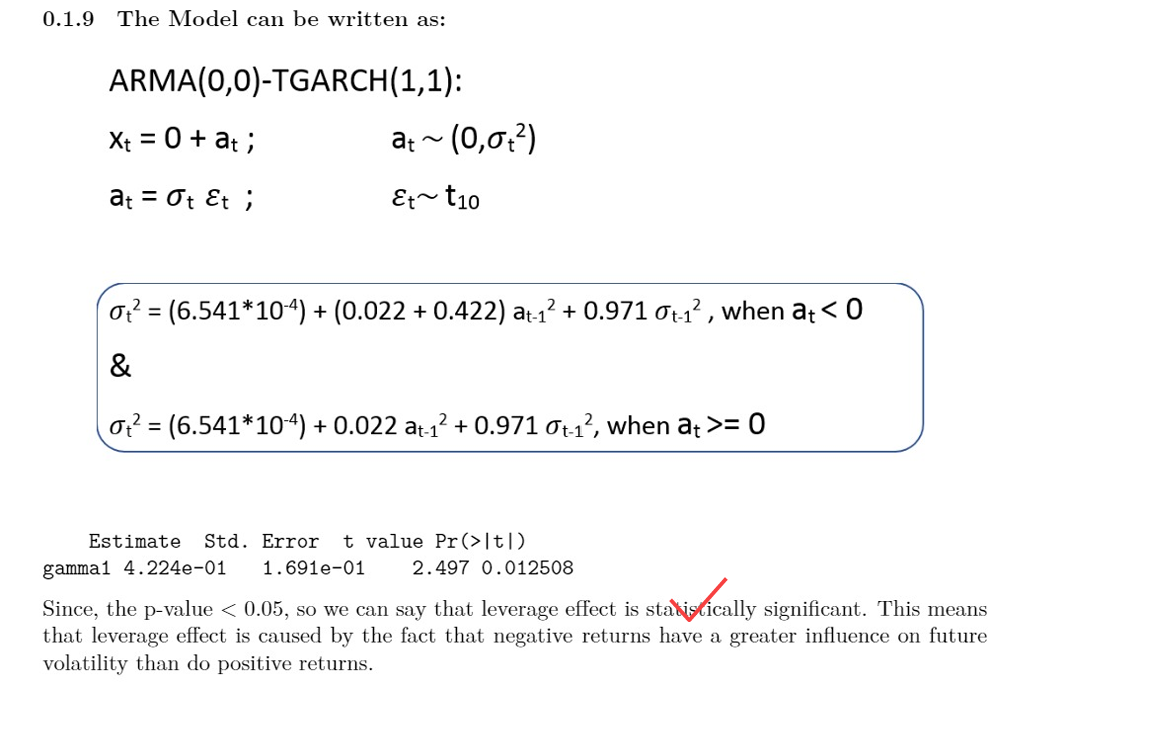